In [1]:
from nlb_tools.nwb_interface import NWBDataset
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
import math
import multiprocessing as mp
from Neural_Decoding.preprocessing_funcs import get_spikes_with_history
from Area2_analysis.lr_funcs import angle_between, process_train_test, gaussian_filter1d_oneside, comp_cc,xcorr
from Area2_analysis.lr_funcs import get_sses_pred, get_sses_mean, nans, fit_and_predict, fit_and_predict_LDGF, sub_and_predict, pred_with_new_weights, pred_with_new_LDGF
matplotlib.rc('font', size=18)

2025-02-14 11:32:33.429375: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [25]:
import importlib
import Area2_analysis.lr_funcs
importlib.reload(Area2_analysis.lr_funcs)
from Area2_analysis.lr_funcs import fit_and_predict_LDGF, retrieve_LDGF

# PyTorch basics - Linear Regression from scratch

In [ ]:
# https://www.kaggle.com/code/aakashns/pytorch-basics-linear-regression-from-scratch

In [ ]:
import torch
import numpy as np
# Create tensors.
x = torch.tensor(3.)
w = torch.tensor(4., requires_grad=True)
b = torch.tensor(5., requires_grad=True)
print(x)
print(w)
print(b)

In [ ]:
y = w * x + b
print(y)
# What makes PyTorch special, is that we can automatically compute the derivative of y 
# w.r.t. the tensors that have requires_grad set to True i.e. w and b.
y.backward()
print('dy/dw:', w.grad)
print('dy/db:', b.grad)

In [ ]:
# Input (temp, rainfall, humidity)
inputs = np.array([[73, 67, 43], 
                   [91, 88, 64], 
                   [87, 134, 58], 
                   [102, 43, 37], 
                   [69, 96, 70]], dtype='float32')
inputs.shape

In [ ]:
targets = np.array([[56, 70], 
                    [81, 101], 
                    [119, 133], 
                    [22, 37], 
                    [103, 119]], dtype='float32')
targets.shape

In [ ]:
inputs = torch.from_numpy(inputs)
targets = torch.from_numpy(targets)
print(inputs)
print(targets)
targets.shape

In [ ]:
# Weights and biases
w = torch.randn(2, 3, requires_grad=True)
b = torch.randn(2, requires_grad=True)
print(w)
print(b)

In [ ]:
# Define the model
def model(x):
    return x @ w.t() + b
# Generate predictions
preds = model(inputs)
print(preds)

In [ ]:
# Compare with targets
print(targets)
# Because we've started with random weights and biases, the model does not a very good job of predicting the target varaibles.

In [ ]:
# We can compare the predictions with the actual targets, using the following method:

# Calculate the difference between the two matrices (preds and targets).
# Square all elements of the difference matrix to remove negative values.
# Calculate the average of the elements in the resulting matrix.
# The result is a single number, known as the mean squared error (MSE).
# MSE loss
def mse(t1, t2):
    diff = t1 - t2
    return torch.sum(diff * diff) / diff.numel()

In [ ]:
# Compute loss
loss = mse(preds, targets)
print(loss)

In [ ]:
# Compute Gradients
# With PyTorch, we can automatically compute the gradient or derivative of the loss w.r.t. to the weights and biases, because they have requires_grad set to True.
loss.backward()

In [ ]:
# The gradients are stored in the .grad property of the respective tensors.
# Gradients for weights
print(w)
print(w.grad)

In [ ]:
# Gradients for bias
print(b)
print(b.grad)

In [ ]:
# A key insight from calculus is that the gradient indicates the rate of change of the loss, or the slope of the loss function w.r.t. the weights and biases.

# If a gradient element is postive,
# increasing the element's value slightly will increase the loss.
# decreasing the element's value slightly will decrease the loss.

# If a gradient element is negative,
# increasing the element's value slightly will decrease the loss.
# decreasing the element's value slightly will increase the loss.

In [ ]:
# Finally, we'll reset the gradients to zero before moving forward, because PyTorch accumulates gradients.

w.grad.zero_()
b.grad.zero_()
print(w.grad)
print(b.grad)

In [ ]:
# Adjust weights and biases using gradient descent¶
# We'll reduce the loss and improve our model using the gradient descent algorithm, which has the following steps:

# 1. Generate predictions
# 2. Calculate the loss
# 3. Compute gradients w.r.t the weights and biases
# 4. Adjust the weights by subtracting a small quantity proportional to the gradient
# 5. Reset the gradients to zero


In [ ]:
# Generate predictions
preds = model(inputs)
print(preds)

In [ ]:
# Calculate the loss
loss = mse(preds, targets)
print(loss)

In [ ]:
# Compute gradients
loss.backward()

In [ ]:
# Adjust weights & reset gradients

# Context-manager that disables gradient calculation.
# Disabling gradient calculation is useful for inference, when you are sure that you will not call Tensor.backward(). 
# It will reduce memory consumption for computations that would otherwise have requires_grad=True.

with torch.no_grad():     
    w -= w.grad * 1e-5
    b -= b.grad * 1e-5
    w.grad.zero_()
    b.grad.zero_()

In [ ]:
print(w)

In [ ]:
# With the new weights and biases, the model should have a lower loss.
# Calculate loss
preds = model(inputs)
loss = mse(preds, targets)
print(loss)

In [ ]:
# Train for 100 epochs
for i in range(100):
    preds = model(inputs)
    loss = mse(preds, targets)
    loss.backward()
    with torch.no_grad():
        w -= w.grad * 1e-5
        b -= b.grad * 1e-5
        w.grad.zero_()
        b.grad.zero_()

In [ ]:
# Calculate loss
preds = model(inputs)
loss = mse(preds, targets)
print(loss)

In [ ]:
# Print predictions
preds

In [ ]:
targets

In [ ]:
# Linear Regression Model using PyTorch built-ins
# Let's re-implement the same model using some built-in functions and classes from PyTorch.

import torch.nn as nn
print(inputs)
print(targets)

In [ ]:
# Dataset and DataLoader
# We'll create a TensorDataset, which allows access to rows from inputs and targets as tuples. 
# We'll also create a DataLoader, to split the data into batches while training. It also provides other utilities like shuffling and sampling
from torch.utils.data import TensorDataset, DataLoader
# Define dataset
train_ds = TensorDataset(inputs, targets)
train_ds[0:3]


In [ ]:
# Define data loader
batch_size = 5
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
next(iter(train_dl))

In [ ]:
# nn.Linear
# Instead of initializing the weights & biases manually, we can define the model using nn.Linear.

# Define model
model = nn.Linear(3, 2)
print(model.weight)
print(model.bias)

In [ ]:
# Optimizer
# Instead of manually manipulating the weights & biases using gradients, we can use the optimizer optim.SGD.

# Define optimizer
opt = torch.optim.SGD(model.parameters(), lr=1e-5)

In [ ]:
# Loss Function
# Instead of defining a loss function manually, we can use the built-in loss function mse_loss.

# Import nn.functional
import torch.nn.functional as F
# Define loss function
loss_fn = F.mse_loss

loss = loss_fn(model(inputs), targets)
print(loss)

In [ ]:
# Train the model
# We are ready to train the model now. We can define a utility function fit which trains the model for a given number of epochs.

# Define a utility function to train the model
def fit(num_epochs, model, loss_fn, opt):
    for epoch in range(num_epochs):
        for xb,yb in train_dl:
            # Generate predictions
            pred = model(xb)
            loss = loss_fn(pred, yb)
            # Perform gradient descent
            loss.backward()
            opt.step()
            opt.zero_grad()
    print('Training loss: ', loss_fn(model(inputs), targets))

In [ ]:
# Train the model for 100 epochs
fit(100, model, loss_fn, opt)

In [ ]:
# Generate predictions
preds = model(inputs)
preds

In [ ]:
# Compare with targets
targets

In [ ]:
# Bonus: Feedfoward Neural Network¶
# Conceptually, you think of feedforward neural networks as two or more linear regression models stacked on top of one another with a non-linear activation function applied between them.

class SimpleNet(nn.Module):
    # Initialize the layers
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(3, 3)
        self.act1 = nn.ReLU() # Activation function
        self.linear2 = nn.Linear(3, 2)
    
    # Perform the computation
    def forward(self, x):
        x = self.linear1(x)
        x = self.act1(x)
        x = self.linear2(x)
        return x

In [ ]:
model = SimpleNet()
opt = torch.optim.SGD(model.parameters(), 1e-5)
loss_fn = F.mse_loss

In [ ]:
fit(100, model, loss_fn, opt)


# linear model

In [3]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
# Define dataset
import torch.nn.functional as F
import torch.nn.utils.parametrize as P
from tqdm import tqdm
from sklearn.metrics import r2_score


In [ ]:
# Input (temp, rainfall, humidity)
inputs = np.array([[73, 67, 43], 
                   [91, 88, 64], 
                   [87, 134, 58], 
                   [102, 43, 37], 
                   [69, 96, 70]], dtype='float32')
inputs.shape

In [ ]:
targets = np.array([[56, 70], 
                    [81, 101], 
                    [119, 133], 
                    [22, 37], 
                    [103, 119]], dtype='float32')
targets.shape

In [ ]:
# inputs = torch.from_numpy(inputs)
# targets = torch.from_numpy(targets)

In [ ]:
# train_ds = TensorDataset(inputs, targets)
# # Define data loader
# batch_size = 5
# train_dl = DataLoader(train_ds, batch_size, shuffle=True)
# next(iter(train_dl))

In [ ]:
# # Define a utility function to train the model
# def fit(num_epochs, model, loss_fn, opt):
#     for epoch in range(num_epochs):
#         for xb,yb in train_dl:
#             # Generate predictions
#             pred = model(xb)
#             loss = loss_fn(pred, yb)
#             # Perform gradient descent
#             loss.backward()
#             opt.step()
#             opt.zero_grad()
#     print('Training loss: ', loss_fn(model(inputs), targets))

In [ ]:
# class LinearModel(nn.Module):
#     def __init__(self, input_dim, output_dim):
#         super().__init__()
#         self.input_dim = input_dim
#         self.output_dim = output_dim
#         self.linear = nn.Linear(input_dim, output_dim)
        
#     def forward(self, x):
#         output = self.linear(x)
#         return output

In [ ]:
# class LDGF(object):
#     def __init__(self, n_epochs=500, learning_rate = 0.01, init = None):
#         self.n_epochs = n_epochs
#         self.init = init
#         self.learning_rate = learning_rate
#     def fit_transform(self, X, Y):
#         model = LinearModel(X.shape[1], Y.shape[1])
            
#         X = torch.tensor(X,dtype=torch.float)
#         y = torch.tensor(Y,dtype=torch.float)

#         model.eval()
#         y_pred = model(X)
#         loss_fn = F.mse_loss
#         loss = loss_fn(y_pred, y)
#         losses=np.zeros(self.n_epochs+1)
#         losses[0]=loss.item()

#         optimizer = torch.optim.Adam(model.parameters(), lr = self.learning_rate)
#         model.train()
#         for epoch in tqdm(range(self.n_epochs), position=0, leave=True):
#             optimizer.zero_grad()
#             # Forward pass
#             y_pred = model(X)
#             # Compute Loss
#             loss = loss_fn(y_pred, y)
#             losses[epoch+1]=loss.item()
#             # Backward pass
#             loss.backward()
#             optimizer.step()
        
#         # Include attributes as part of self
#         self.model=model
#         self.losses=losses
#         self.params={}
#         self.params['weight']=model.linear.state_dict()['weight'].detach().numpy()
#         self.params['bias']=model.linear.state_dict()['bias'].detach().numpy()
#         self.r2_score=r2_score(y,y_pred.detach().numpy())
#         return y_pred.detach().numpy()

In [ ]:
class LinearModel(nn.Module):
    def __init__(self, input_dim, output_dim, weight_init, b_init):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.linear = nn.Linear(input_dim, output_dim, bias = True)
        self.linear.weight = torch.nn.Parameter(torch.tensor(weight_init, dtype=torch.float))
        self.linear.bias = torch.nn.Parameter(torch.tensor(b_init, dtype=torch.float))
        
    def forward(self, x):
        output = self.linear(x)
        return output

In [ ]:
from sklearn.linear_model import LinearRegression
class LDGF(object):
    def __init__(self, n_epochs=3000, learning_rate = None, init = None):
        self.n_epochs = n_epochs
        self.init = init
        self.learning_rate = learning_rate
    def fit_transform(self, X, y):
        if self.init is None:
            weight_init = np.random.randn(X.shape[1], y.shape[1]).T
            b_init = np.zeros(y.shape[1])
        elif self.init == 'linear_regression':
            reg = LinearRegression().fit(X, y)
            weight_init = reg.coef_
            b_init = reg.intercept_

        if self.learning_rate == None:
            if self.init == 'linear_regression':
                self.learning_rate = 0.001
            elif self.init is None:
                self.learning_rate = 0.01
            
        model = LinearModel(X.shape[1], y.shape[1], weight_init, b_init)
            
        X = torch.tensor(X,dtype=torch.float)
        y = torch.tensor(y,dtype=torch.float)

        model.eval()
        y_pred = model(X)
        loss_fn = F.mse_loss
        loss = loss_fn(y_pred, y)
        losses=np.zeros(self.n_epochs+1)
        losses[0]=loss.item()

        optimizer = torch.optim.Adam(model.parameters(), lr = self.learning_rate)
        model.train()
        for epoch in tqdm(range(self.n_epochs), position=0, leave=True):
            optimizer.zero_grad()
            # Forward pass
            y_pred = model(X)
            # Compute Loss
            loss = loss_fn(y_pred, y)
            losses[epoch+1]=loss.item()
            # Backward pass
            loss.backward()
            optimizer.step()
        
        # Include attributes as part of self
        self.model=model
        self.losses=losses
        self.params={}
        self.params['weight']=model.linear.weight.detach().numpy()
        self.params['bias']=model.linear.bias.detach().numpy()
        self.r2_score=r2_score(y,y_pred.detach().numpy())
        return y_pred.detach().numpy()

In [ ]:
ldgf=LDGF()
y_pred=ldgf.fit_transform(X=inputs, y=targets)
print(y_pred)
y_true = targets
print(y_true)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(ldgf.losses)
plt.xlabel('epoch')
plt.ylabel('loss')
print('loss',ldgf.losses[-1])
print('r2',ldgf.r2_score)
print('weight',ldgf.params['weight'])
print('bias',ldgf.params['bias'])

In [ ]:
y_pred

In [ ]:
plt.plot(y_true[:,0],label='true')
plt.plot(y_pred[:,0],label='predicted')
plt.legend()
plt.title('feature 1')
plt.show()
plt.plot(y_true[:,1],label='true')
plt.plot(y_pred[:,1],label='predicted')
plt.legend()
plt.title('feature 2')


## Simulate data

In [ ]:
np.random.seed(0)

In [ ]:
T= 200 #Time
N_neurons = 10
N_features = 2
X0 = np.random.randn(T,N_neurons)
w0 = np.random.randn(N_neurons, N_features)
print(X0.shape)
print(w0.shape)
b0 = np.random.randn(N_features)
Y0 = X0 @ w0 + b0
print(Y0.shape)

In [ ]:
plt.figure(figsize=(10,5))
N_plot_neurons = 7
for i in range(N_plot_neurons):
    
    #Plot ground truth
    plt.subplot(N_plot_neurons,2,2*i+1)
    plt.plot((X0)[:,i]) 
    
    # plt.yticks([])
    if i<N_plot_neurons-1:
        plt.xticks([])
    else:
        plt.xlabel('Time')
for i in range(N_features):
    plt.subplot(N_plot_neurons,2,2*i+2)
    plt.plot((Y0)[:,i]) 
    # plt.yticks([])    
    if i<N_features-1:
        plt.xticks([])
    else:
        plt.xlabel('Time')

plt.subplot(N_plot_neurons,2,1)
plt.title('Simulated neurons')

plt.subplot(N_plot_neurons,2,2)
plt.title('Simulated features')

In [ ]:
# ldgf=LDGF(init='linear_regression')
ldgf=LDGF()

y_pred=ldgf.fit_transform(X=X0, y=Y0)
print(y_pred)
y_true = Y0
print(y_true)

In [ ]:
plt.plot(y_true[:,0],label='true')
plt.plot(y_pred[:,0],label='predicted')
plt.legend()
plt.title('feature 1')
plt.show()
plt.plot(y_true[:,1],label='true')
plt.plot(y_pred[:,1],label='predicted')
plt.legend()
plt.title('feature 2')


In [ ]:
print('true weight',w0)
print('true bias',b0)

In [ ]:
plt.plot(ldgf.losses)
plt.xlabel('epoch')
plt.ylabel('loss')
print('loss',ldgf.losses[-1])
print('r2',ldgf.r2_score)
print('pred weight',ldgf.params['weight'].T)
print('pred bias',ldgf.params['bias'])

## Simulate data + add filter

In [ ]:
def gaussian_filter(x, sigma):
    return np.exp(-0.5*((x)/sigma)**2)

In [ ]:
filter_length = 41
x_range = np.arange(-filter_length//2+1, filter_length//2+1)
sigmas = [2,5]
gaussian_filter_list = [gaussian_filter(x_range,sigmas[j]) for j in range(N_features)]

Y0_with_filter = np.stack([np.convolve(Y0[:,j], filter, mode='same') for j, filter in enumerate(gaussian_filter_list)]).T
print(Y0_with_filter.shape)

In [ ]:
filter = gaussian_filter(x_range, sigma=2)
X0_with_filter = np.stack([np.convolve(X0[:,j], filter,mode='same') for j in range(X0.shape[1])]).T
print(X0_with_filter.shape)

In [ ]:
plt.figure(figsize=(15,5))
N_plot_neurons = 7
for i in range(N_plot_neurons):
    
    #Plot ground truth
    plt.subplot(N_plot_neurons,3,3*i+1)
    plt.plot((X0)[:,i]) 
    
    # plt.yticks([])
    if i<N_plot_neurons-1:
        plt.xticks([])
    else:
        plt.xlabel('Time')

for i in range(N_plot_neurons):
    
    #Plot ground truth
    plt.subplot(N_plot_neurons,3,3*i+2)
    plt.plot((X0_with_filter)[:,i]) 
    
    # plt.yticks([])
    if i<N_plot_neurons-1:
        plt.xticks([])
    else:
        plt.xlabel('Time')

# for i in range(N_features):
    # plt.subplot(N_plot_neurons,3,3*i+2)
    # plt.plot((Y0)[:,i]) 
    # # plt.yticks([])    
    # if i<N_features-1:
    #     plt.xticks([])
    # else:
    #     plt.xlabel('Time')

for i in range(N_features):
    plt.subplot(N_plot_neurons,3,3*i+3)
    plt.plot((Y0_with_filter)[:,i]) 
    # plt.yticks([])    
    if i<N_features-1:
        plt.xticks([])
    else:
        plt.xlabel('Time')

plt.subplot(N_plot_neurons,3,1)
plt.title('Simulated neurons')


plt.subplot(N_plot_neurons,3,2)
plt.title('Simulated neurons, filtered')

# plt.subplot(N_plot_neurons,3,2)
# plt.title('Simulated features')

plt.subplot(N_plot_neurons,3,3)
plt.title('Simulated features, filtered')

In [ ]:
ldgf=LDGF(init='linear_regression')
# ldgf=LDGF()

# y_pred=ldgf.fit_transform(X=X0, y=Y0)
# y_pred=ldgf.fit_transform(X=X0, y=Y0_with_filter)
y_pred=ldgf.fit_transform(X=X0_with_filter, y=Y0_with_filter)


print(y_pred)
# y_true = Y0
y_true = Y0_with_filter
print(y_true)

In [ ]:
r2_score(y_true, y_pred)

In [ ]:
plt.plot(y_true[:,0],label='true')
plt.plot(y_pred[:,0],label='predicted')
plt.legend()
plt.title('feature 1')
plt.show()
plt.plot(y_true[:,1],label='true')
plt.plot(y_pred[:,1],label='predicted')
plt.legend()
plt.title('feature 2')


In [ ]:
print('true weight',w0)
print('true bias',b0)

In [ ]:
plt.plot(ldgf.losses)
plt.xlabel('epoch')
plt.ylabel('loss')
print('loss',ldgf.losses[-1])
print('r2',ldgf.r2_score)
print('pred weight',ldgf.params['weight'].T)
print('pred bias',ldgf.params['bias'])

# filter model

## Model

In [26]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
# Define dataset
import torch.nn.functional as F
import torch.nn.utils.parametrize as P
from tqdm import tqdm
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

from ldgf.model import LDGF   

import importlib
import ldgf.model
importlib.reload(ldgf.model)
from ldgf.model import LDGF


In [27]:
import numpy
import dateutil
import pytz

print(numpy.__version__)
print(dateutil.__version__)
print(pytz.__version__)
import hdmf
print(hdmf.__version__)


1.22.0
2.8.1
2021.1
3.6.1


In [ ]:
import pynwb
print(pynwb.__version__)


## Simulation

In [51]:
def gaussian_filter(x, sigma,filter_length):
    return np.exp(-0.5*((x)/sigma)**2)
def causal_filter(x, sigma,filter_length):
    phi_x = np.exp(-0.5*((x)/sigma)**2)
    phi_x[:filter_length//2] = 0
    return phi_x
def anticausal_filter(x, sigma,filter_length):
    phi_x = np.exp(-0.5*((x)/sigma)**2)
    phi_x[-filter_length//2+1:] = 0
    return phi_x

In [6]:
np.random.seed(0)

In [52]:
T= 200 #Time
N_neurons = 10
N_features = 2
X0 = np.ones([T,N_neurons])
X0[:50,:]=0
X0[-50:,:]=0
w0 = np.random.randn(N_neurons, N_features)
print(w0.shape)
b0 = np.random.randn(N_features)
Y0 = X0 @ w0 + b0
print(X0.shape)
print(Y0.shape)

(10, 2)
(200, 10)
(200, 2)


In [63]:
filter_length = 41
x_range = np.arange(-filter_length//2+1, filter_length//2+1)
sigmas = [2,5]
# filter_list = [gaussian_filter(x_range,sigmas[j],filter_length) for j in range(N_features)]
filter_list = [causal_filter(x_range,sigmas[j],filter_length) for j in range(N_features)]
# filter_list = [anticausal_filter(x_range,sigmas[j],filter_length) for j in range(N_features)]

Y0_with_filter_valid = np.stack([np.convolve(Y0[:,j], filter, mode='valid') for j, filter in enumerate(filter_list)]).T
Y0_with_filter_valid = Y0_with_filter_valid.reshape(1,Y0_with_filter_valid.shape[0], Y0_with_filter_valid.shape[1])


Y0_with_filter_full = np.stack([np.convolve(Y0[:,j], filter, mode='full') for j, filter in enumerate(filter_list)]).T
Y0_with_filter_full = Y0_with_filter_full.reshape(1,Y0_with_filter_full.shape[0], Y0_with_filter_full.shape[1])


filter_list = [causal_filter(x_range,sigmas[j],filter_length) for j in range(N_features)]
Y0_with_filter = np.stack([np.convolve(Y0[:,j], filter, mode='same') for j, filter in enumerate(filter_list)]).T
Y0_with_filter = Y0_with_filter.reshape(1,Y0_with_filter.shape[0], Y0_with_filter.shape[1])
print(Y0_with_filter.shape)

(1, 200, 2)


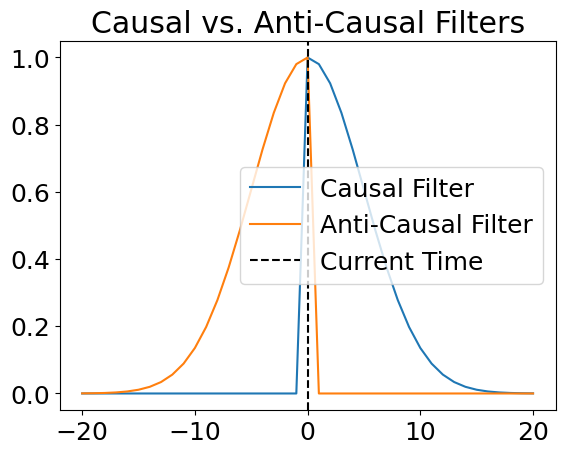

In [20]:
import numpy as np
import matplotlib.pyplot as plt

filter_length = 41
sigma = 5.0
x = np.arange(-filter_length // 2 + 1, filter_length // 2 + 1)

causal = causal_filter(x, sigma, filter_length)
anticausal = anticausal_filter(x, sigma, filter_length)

plt.plot(x, causal, label='Causal Filter')
plt.plot(x, anticausal, label='Anti-Causal Filter')
plt.axvline(0, color='k', linestyle='--', label='Current Time')
plt.legend()
plt.title("Causal vs. Anti-Causal Filters")
plt.show()

1.0


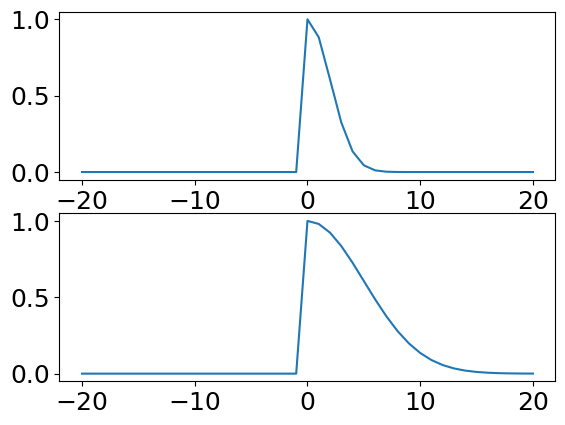

In [21]:
import matplotlib.pyplot as plt
for i in range(N_features):
    plt.subplot(N_features, 1,i+1)
    plt.plot(x_range,filter_list[i],label='true filter')
print(filter_list[0][np.argwhere(x_range==0)[0][0]])

In [84]:
# filter = gaussian_filter(x_range, sigma=2)
# X0_with_filter = np.stack([np.convolve(X0[:,j], filter,mode='same') for j in range(X0.shape[1])]).T
# X0_with_filter = X0_with_filter.reshape(1,X0_with_filter.shape[0], X0_with_filter.shape[1])
# print(X0_with_filter.shape)
X0 = X0.reshape(1,X0.shape[0], X0.shape[1])
Y0 = Y0.reshape(1,Y0.shape[0], Y0.shape[1])
print(X0.shape)
print(Y0.shape)

(1, 200, 10)
(1, 200, 2)


Text(0.5, 1.0, 'Simulated features, causal filtered')

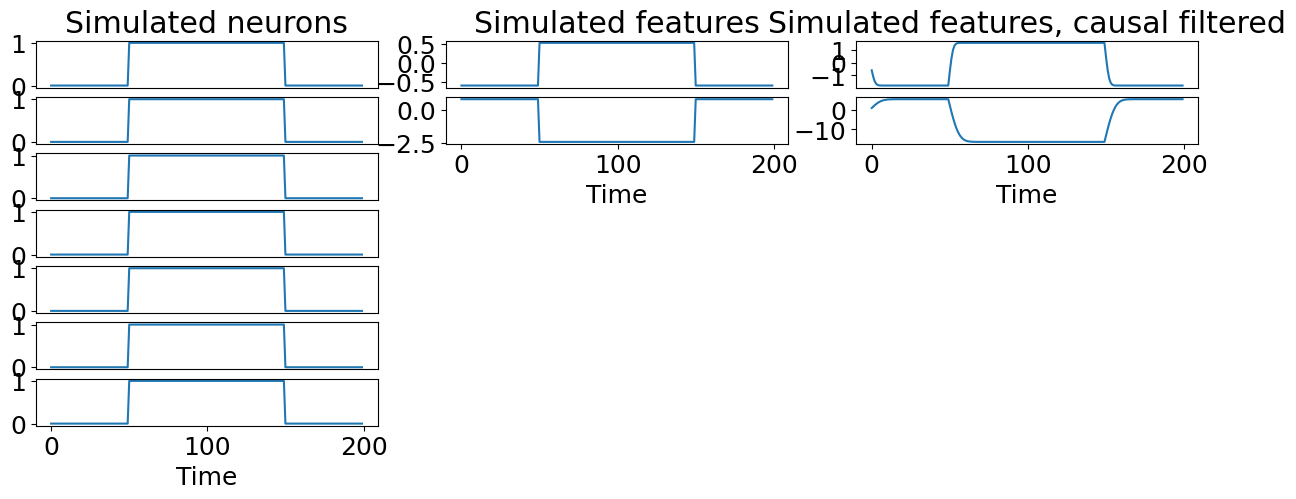

In [85]:
plt.figure(figsize=(15,5))
N_plot_neurons = 7
for i in range(N_plot_neurons):
    
    #Plot ground truth
    plt.subplot(N_plot_neurons,3,3*i+1)
    plt.plot((X0)[0,:,i]) 
    
    # plt.yticks([])
    if i<N_plot_neurons-1:
        plt.xticks([])
    else:
        plt.xlabel('Time')


for i in range(N_features):
    plt.subplot(N_plot_neurons,3,3*i+2)
    plt.plot((Y0)[0,:,i]) 
    # plt.yticks([])    
    if i<N_features-1:
        plt.xticks([])
    else:
        plt.xlabel('Time')

for i in range(N_features):
    plt.subplot(N_plot_neurons,3,3*i+3)
    plt.plot((Y0_with_filter)[0,:,i]) 
    # plt.yticks([])    
    if i<N_features-1:
        plt.xticks([])
    else:
        plt.xlabel('Time')


plt.subplot(N_plot_neurons,3,1)
plt.title('Simulated neurons')


plt.subplot(N_plot_neurons,3,2)
plt.title('Simulated features')

plt.subplot(N_plot_neurons,3,3)
plt.title('Simulated features, causal filtered')

In [ ]:
# ldgf=LDGF(init='linear_regression',n_epochs=6000)
ldgf=LDGF(filter_type = 'gaussian',n_epochs=8000)
# ldgf=LDGF(add_filter = False)


# y_pred=ldgf.fit_transform(X=X0, y=Y0)
y_pred=ldgf.fit_transform(X=X0, y=Y0_with_filter)
# y_pred=ldgf.fit_transform(X=X0_with_
# filter, y=Y0_with_filter)

print(y_pred)
# y_true = Y0
y_true = Y0_with_filter
print(y_true)

In [ ]:
plt.plot(y_true[0,:,0],label='true')
plt.plot(y_pred[0,:,0],label='predicted')
plt.legend()
plt.title('feature 1')
plt.show()
plt.plot(y_true[0,:,1],label='true')
plt.plot(y_pred[0,:,1],label='predicted')
plt.legend()
plt.title('feature 2')


In [ ]:
print('true weight',w0)
print('true bias',b0)

In [ ]:
plt.plot(ldgf.losses)
plt.xlabel('epoch')
plt.ylabel('loss')
print('loss',ldgf.losses[-1])
print('r2',ldgf.r2_score)
print('pred weight',ldgf.params['weight'].T)
print('pred bias',ldgf.params['bias'])

In [ ]:
x, y = ldgf.model.plottable_filters()
sigmas = ldgf.model.get_sigmas()
print(sigmas)
j=0
for i in range(N_features):
    plt.subplot(N_features, 1,i+1)
    plt.plot(x,filter_list[i],label='true filter')
    plt.plot(x,y[i][::-1],label='pred filter')
    if i < N_features-1:
        plt.xticks([])
    j+=2
plt.legend()

## Real data

### Import

In [ ]:
foldername = "~/area2_population_analysis/s1-kinematics/actpas_NWB/"
# monkey = "Han_20171207"
# filename = foldername + monkey + "_COactpas_TD_offset2.nwb"

monkey = 'Duncan_20190710'
filename = foldername + monkey + "_COactpas_offset2.nwb"

dataset_10ms = NWBDataset(filename, split_heldout=False)
dataset_10ms.resample(10) #in 10-ms bin, has to resample first to avoid NaNs
bin_width = dataset_10ms.bin_width
print(bin_width)
xy_vel = dataset_10ms.data['hand_vel'].to_numpy() 
# xy_acc = np.diff(xy_vel, axis = 0, prepend=[xy_vel[0]])
# dataset_10ms.add_continuous_data(xy_acc,'hand_acc',chan_names = ['x','y'])
# dataset_10ms.smooth_spk(40, name='smth_40')

In [ ]:
x_field = 'spikes'
data = np.load(monkey+'_unsmoothed50_cdfb_data_'+x_field+'.npz')
data.files
dataset_10ms.add_continuous_data(data['CD_FB_proj'],'CD_FB_proj')
dataset_10ms.add_continuous_data(data['CD_proj'],'CD_proj')
dataset_10ms.add_continuous_data(data['FB_proj'],'FB_proj')
dataset_10ms.data.keys().unique(0)

In [ ]:
n_trials = dataset_10ms.trial_info.shape[0]
print(n_trials,'total trials')
n_neurons = dataset_10ms.data.spikes.shape[1]
print(n_neurons,'neurons')

n_dims = 20 # for PCA

all_data = np.array(dataset_10ms.data.spikes)
print(all_data.shape)
if not np.isnan(all_data).any():
    scaler = StandardScaler()
    X = scaler.fit_transform(all_data)
    pca = PCA(n_components=n_dims,random_state = 42)
    PCA_data = pca.fit_transform(X)
print(PCA_data.shape)
dataset_10ms.add_continuous_data(PCA_data,'PCA')
print('PCA total var explained:',sum(pca.explained_variance_ratio_))

n_trials = dataset_10ms.trial_info.shape[0]
print(n_trials,'total trials')
n_neurons = dataset_10ms.data.spikes.shape[1]
print(n_neurons,'neurons')

# all_data = np.array(dataset_10ms.data.spikes_smth_40)
# print(all_data.shape)
# if not np.isnan(all_data).any():
#     scaler = StandardScaler()
#     X = scaler.fit_transform(all_data)
#     pca = PCA(n_components=n_dims,random_state = 42)
#     PCA_data = pca.fit_transform(X)
# print(PCA_data.shape)
# dataset_10ms.add_continuous_data(PCA_data,'PCA_40')
# print('PCA total var explained:',sum(pca.explained_variance_ratio_))


In [ ]:
#make dictionary for trial condition (reaching directions) for Stratified CV
dataset = dataset_10ms
active_mask = (dataset.trial_info.ctr_hold_bump==0) & (dataset.trial_info['split'] != 'none')
passive_mask = (dataset.trial_info.ctr_hold_bump==1) & (dataset.trial_info['split'] != 'none')
nan_mask = (np.isnan(dataset.trial_info.ctr_hold_bump)) & (dataset.trial_info['split'] != 'none')
all_mask = (dataset.trial_info['split'] != 'none')

trial_mask = all_mask
valid_n_trials = dataset.trial_info.loc[trial_mask].shape[0]
print(valid_n_trials,'valid trials')

trial_mask = active_mask
active_trials_idx = np.array(dataset.trial_info.loc[trial_mask]['trial_id'])
active_n_trials = dataset.trial_info.loc[trial_mask].shape[0]
print(active_n_trials,'active trials')

trial_mask = passive_mask
passive_trials_idx = np.array(dataset.trial_info.loc[trial_mask]['trial_id'])
passive_n_trials = dataset.trial_info.loc[trial_mask].shape[0]
print(passive_n_trials,'passive trials')

trial_mask = nan_mask
nan_trials_idx = np.array(dataset.trial_info.loc[trial_mask]['trial_id'])
nan_n_trials = dataset.trial_info.loc[trial_mask].shape[0]
print(nan_n_trials,'reach bump trials')

active_cond_dir_idx = []
passive_cond_dir_idx = []
nan_cond_dir_idx = []
nan_bump_cond_dir_idx = []
for direction in [0,45,90,135,180,225,270,315]:
# for direction in [0,90,180,270]:
    active_cond_dir_idx.append(np.where((dataset.trial_info['cond_dir']%360 == direction) & (dataset.trial_info['ctr_hold_bump'] == 0) & \
           (dataset.trial_info['split'] != 'none'))[0])
    passive_cond_dir_idx.append(np.where((dataset.trial_info['cond_dir']%360 == direction) & (dataset.trial_info['ctr_hold_bump'] == 1) & \
           (dataset.trial_info['split'] != 'none'))[0])
    nan_cond_dir_idx.append(np.where((dataset.trial_info['cond_dir']%360 == direction) & (np.isnan(dataset.trial_info.ctr_hold_bump)) & \
           (dataset.trial_info['split'] != 'none'))[0])
    nan_bump_cond_dir_idx.append(np.where((dataset.trial_info['bump_dir']%360 == direction) & (np.isnan(dataset.trial_info.ctr_hold_bump)) & \
           (dataset.trial_info['split'] != 'none'))[0])

active_cond_dict = nans([active_n_trials])
i = 0
for idx in active_trials_idx:
    for cond in range(0,len(active_cond_dir_idx)):
        if idx in active_cond_dir_idx[cond]:
            active_cond_dict[i] = cond
            break
    i+=1
print(active_cond_dict)
print(len(active_cond_dict))

passive_cond_dict = nans([passive_n_trials])
i = 0
for idx in passive_trials_idx:
    for cond in range(0,len(passive_cond_dir_idx)):
        if idx in passive_cond_dir_idx[cond]:
            passive_cond_dict[i] = cond
            break
    i+=1
print(passive_cond_dict)
print(len(passive_cond_dict))

nan_cond_dict = nans([nan_n_trials])
i = 0
for idx in nan_trials_idx:
    for cond in range(0,len(nan_cond_dir_idx)):
        if idx in nan_cond_dir_idx[cond]:
            nan_cond_dict[i] = cond
            break
    i+=1
print(nan_cond_dict)
print(len(nan_cond_dict))

nan_bump_cond_dict = nans([nan_n_trials])
i = 0
for idx in nan_trials_idx:
    for cond in range(0,len(nan_bump_cond_dir_idx)):
        if idx in nan_bump_cond_dir_idx[cond]:
            nan_bump_cond_dict[i] = cond
            break
    i+=1
print(nan_bump_cond_dict)
print(len(nan_bump_cond_dict))

In [ ]:
passive_df = dataset_10ms.make_trial_data(align_field='move_onset_time', align_range = (-100,100), ignored_trials = ~passive_mask)
set(passive_trials_idx) - set(passive_df['trial_id'].unique())

In [ ]:
active_df = dataset_10ms.make_trial_data(align_field='move_onset_time', align_range = (-100,100), ignored_trials = ~active_mask)
del_indices = list(set(active_trials_idx) - set(active_df['trial_id'].unique()))
print('was',active_n_trials,'active trials')
active_n_trials = active_n_trials - len(list(set(active_trials_idx) - set(active_df['trial_id'].unique())))
active_cond_dict = np.delete(active_cond_dict,np.argwhere(active_trials_idx==del_indices)[0])
print('now',active_n_trials,'active trials')
print(len(active_cond_dict))

In [ ]:
# from sca.models import SCA
# align_range = (-100, 500)
# active_trial_data = dataset_10ms.make_trial_data(align_field='move_onset_time', align_range=align_range, ignored_trials=~active_mask)
# active_trial_spsm = np.array(active_trial_data.spikes_smth_40)
# target_n_trials = active_trial_data['trial_id'].nunique()
# n_timepoints = int((align_range[1]-align_range[0])/bin_width)
# active_sample_weights= np.ones((target_n_trials, n_timepoints))
# # active_sample_weights[:,:int(100/dataset_10ms.bin_width)] = 10
# active_sample_weights = active_sample_weights.flatten()
# print(active_sample_weights.shape)

# align_range = (-100, 500)
# passive_trial_data = dataset_10ms.make_trial_data(align_field='move_onset_time', align_range=align_range, ignored_trials=~passive_mask)
# passive_trial_spsm = np.array(passive_trial_data.spikes_smth_40)
# target_n_trials = passive_trial_data['trial_id'].nunique()
# n_timepoints = int((align_range[1]-align_range[0])/bin_width)
# passive_sample_weights= np.ones((target_n_trials, n_timepoints))
# passive_sample_weights = passive_sample_weights.flatten()
# print(passive_sample_weights.shape)

# sample_weights = np.hstack((active_sample_weights, passive_sample_weights))
# print(sample_weights.shape)
# all_trial_spsm = np.concatenate((active_trial_spsm, passive_trial_spsm),axis=0)
# print(all_trial_spsm.shape)

# all_data = np.array(dataset_10ms.data.spikes_smth_40)
# print(all_data.shape)
# if not np.isnan(all_trial_spsm).any():
#     scaler = StandardScaler()
#     X_trial = scaler.fit_transform(all_trial_spsm,sample_weight=sample_weights)
#     sca = SCA(n_components=n_dims)
#     sca.fit(X_trial) # scaler and sca fit to trial data
#     X_all = scaler.transform(all_data) #scaler and sca transform all data
#     SCA_data = sca.transform(X_all)
# print(SCA_data.shape)
# dataset_10ms.add_continuous_data(SCA_data,'SCA_40')
# print('SCA_40 var explained:',sca.r2_score)
# ssa_order_smth40=np.argsort(-np.array(sca.explained_squared_activity))
# print('SCA_40 activity explained:',sca.explained_squared_activity[ssa_order_smth40])


In [ ]:
# all_data = np.array(dataset_10ms.data.spikes)
# X_all = scaler.transform(all_data) #scaler and sca transform all data
# SCA_data = sca.transform(X_all)
# print(SCA_data.shape)
# dataset_10ms.add_continuous_data(SCA_data,'SCA')
# print('SCA var explained:',sca.r2_score)
# ssa_order_smth40=np.argsort(-np.array(sca.explained_squared_activity))
# print('SCA_40 activity explained:',sca.explained_squared_activity[ssa_order_smth40])

In [ ]:
# # Plot PCA projections over trial, for different reaching directions
# plot_field = 'SCA_40'
# order = ssa_order_smth40

# pred_range = (-100, 1000)
# trial_mask = active_mask
# cond_dict = active_cond_dict
# n_timepoints = int((pred_range[1] - pred_range[0])/dataset_10ms.bin_width)
# # n_trials = dataset_10ms.trial_info.loc[trial_mask].shape[0]
# data = dataset_10ms.make_trial_data(align_field='move_onset_time', align_range=pred_range, ignored_trials=~trial_mask)
# n_trials = data['trial_id'].nunique()
# trials_pca = nans([n_trials,n_timepoints,n_dims])
# i = 0
# for idx, trial in data.groupby('trial_id'):
#     trials_pca[i,:,:]=trial[plot_field].to_numpy()
#     i+=1
# print(trials_pca.shape)

# plot_dir = np.array([0,45,90,135,180,225,270,315]) 
# directions = np.array([0,45,90,135,180,225,270,315])

# # plot_dir = np.array([0,90,180,270]) 
# # directions = np.array([0,90,180,270])

# x_axis = np.arange(pred_range[0], pred_range[1], dataset_10ms.bin_width)

# # define some useful time points
# move_idx=0
# ret_idx = 120

# import matplotlib as mpl
# cmap = plt.get_cmap('coolwarm',len(plot_dir))
# custom_palette = [mpl.colors.rgb2hex(cmap(i)) for i in range(len(plot_dir))]

# plot_dims = 10

# fig,ax=plt.subplots(plot_dims,1,figsize=(10,12))
# for i in range(plot_dims):
#     for j in range(len(plot_dir)):
#         color = custom_palette[j]
#         dir_idx = np.argwhere(directions == plot_dir[j])[0]
#         cond_mean_proj = np.mean(trials_pca[np.argwhere(cond_dict==dir_idx).flatten(),:,:], axis = 0)[:,order[i]] 
#         pca_mean = np.mean(data[plot_field].to_numpy(),axis = 0)[order[i]] 
#         ax[i].plot(x_axis,cond_mean_proj - pca_mean,linewidth=2.25,color = color,label = plot_dir[j])
        
#         ax[i].axvline(move_idx, color='k',linewidth = .5)
#         ax[i].axvline(ret_idx, color='k',linewidth = .5)
#         ax[i].set_xlim([-100,1000])
#         # ax[i].set_ylim([-15, 15])
#         ax[i].axhline(0,color ='k',ls = '--')
#         if i<plot_dims-1:
#             ax[i].set_xticks([])
#         else:
#             ax[i].set_xlabel('Time after movement onset (ms)')
            
#         ax[i].set_yticks([])
#         ax[i].set_ylabel('Dim. '+str(i+1))

#     ax[0].set_title('Active trials')
    
# plt.legend(bbox_to_anchor = (1, 1), loc = 'upper left')
# plt.tight_layout()
# # plt.savefig(figDir + monkey + '_PCA_active.pdf',dpi = 'figure')

### Try model

In [ ]:
dataset = dataset_10ms
x_field = 'CD_proj'
y_field ='hand_vel'
n_features = 2
lag_axis = np.arange(-300,320,20)
trial_mask = active_mask
cond_dict = active_cond_dict
# trial_mask = passive_mask
# cond_dict = passive_cond_dict

figDir = '/Users/sherryan/area2_population_analysis/figures_plus/PCA/'
dim = dataset_10ms.data[x_field].shape[1]
dim

In [ ]:
import scipy.stats
filter = True
filter_type = 'causal'
init = None
pred_range = (-500, 1400)
r2_array = nans([len(lag_axis)]); r2_wo_filter_array = nans([len(lag_axis)]); 
x_r2_array = nans([len(lag_axis)]); y_r2_array = nans([len(lag_axis)])
r_array = nans([len(lag_axis)])
coef_array = nans([len(lag_axis),2,dim])
sigmas_list = []
if filter:
    for i in range(len(lag_axis)):
        lag = lag_axis[i]
        print(lag)
        r2, r2_wo, ldgf, vel_df, r2_arr, sigmas = fit_and_predict_LDGF(dataset, trial_mask, 'move_onset_time',pred_range, lag, x_field, y_field,cond_dict,filter=filter,filter_type=filter_type,init=init)
        coef,bias = ldgf.params['weight'],ldgf.params['bias']
        r2_array[i] = r2; r2_wo_filter_array[i] = r2_wo
        x_r2_array[i] = r2_arr[0]; y_r2_array[i] = r2_arr[1]
        r = scipy.stats.pearsonr(vel_df[y_field].to_numpy().reshape(-1), vel_df['pred_vel'].to_numpy().reshape(-1))[0]
        r_array[i] = r
        coef_array[i,:,:] = coef
        sigmas_list.append(sigmas)
    time_max = lag_axis[np.argmax(r2_array)]
    print(np.max(r2_array))
    ldgf_best, vel_df, best_sigmas = retrieve_LDGF(dataset, trial_mask, 'move_onset_time',pred_range, time_max, x_field, y_field, cond_dict=cond_dict,filter=filter,filter_type=filter_type,init=init)
    print(best_sigmas)
    best_coef,best_intercept = ldgf_best.params['weight'], ldgf_best.params['bias']
    np.savez(monkey+'_'+x_field+'_'+y_field+'_'+filter_type+'_81filter', r2_array = r2_array, r2_wo_filter_array = r2_wo_filter_array, x_r2_array = x_r2_array, y_r2_array = y_r2_array, r_array = r_array,\
            coef_array = coef_array, time_max = time_max, best_coef = best_coef, best_intercept = best_intercept, best_sigmas = best_sigmas) 

In [ ]:
import scipy.stats
filter = True
filter_type = 'gaussian'
init = None
pred_range = (-500, 1400)
r2_array = nans([len(lag_axis)]); r2_wo_filter_array = nans([len(lag_axis)]); 
x_r2_array = nans([len(lag_axis)]); y_r2_array = nans([len(lag_axis)])
r_array = nans([len(lag_axis)])
coef_array = nans([len(lag_axis),2,dim])
sigmas_list = []
if filter:
    for i in range(len(lag_axis)):
        lag = lag_axis[i]
        print(lag)
        r2, r2_wo, ldgf, vel_df, r2_arr, sigmas = fit_and_predict_LDGF(dataset, trial_mask, 'move_onset_time',pred_range, lag, x_field, y_field,cond_dict,filter=filter,filter_type=filter_type,init=init)
        coef,bias = ldgf.params['weight'],ldgf.params['bias']
        r2_array[i] = r2; r2_wo_filter_array[i] = r2_wo
        x_r2_array[i] = r2_arr[0]; y_r2_array[i] = r2_arr[1]
        r = scipy.stats.pearsonr(vel_df[y_field].to_numpy().reshape(-1), vel_df['pred_vel'].to_numpy().reshape(-1))[0]
        r_array[i] = r
        coef_array[i,:,:] = coef
        sigmas_list.append(sigmas)
    time_max = lag_axis[np.argmax(r2_array)]
    print(np.max(r2_array))
    ldgf_best, vel_df, best_sigmas = retrieve_LDGF(dataset, trial_mask, 'move_onset_time',pred_range, time_max, x_field, y_field, cond_dict=cond_dict,filter=filter,filter_type=filter_type,init=init)
    print(best_sigmas)
    best_coef,best_intercept = ldgf_best.params['weight'], ldgf_best.params['bias']
    np.savez(monkey+'_'+x_field+'_'+y_field+'_'+filter_type+'_81filter', r2_array = r2_array, r2_wo_filter_array = r2_wo_filter_array, x_r2_array = x_r2_array, y_r2_array = y_r2_array, r_array = r_array,\
            coef_array = coef_array, time_max = time_max, best_coef = best_coef, best_intercept = best_intercept, best_sigmas = best_sigmas) 

In [ ]:
import scipy.stats
filter = True
filter_type = 'anti-causal'
init = None
pred_range = (-500, 1400)
r2_array = nans([len(lag_axis)]); r2_wo_filter_array = nans([len(lag_axis)]); 
x_r2_array = nans([len(lag_axis)]); y_r2_array = nans([len(lag_axis)])
r_array = nans([len(lag_axis)])
coef_array = nans([len(lag_axis),2,dim])
sigmas_list = []
if filter:
    for i in range(len(lag_axis)):
        lag = lag_axis[i]
        print(lag)
        r2, r2_wo, ldgf, vel_df, r2_arr, sigmas = fit_and_predict_LDGF(dataset, trial_mask, 'move_onset_time',pred_range, lag, x_field, y_field,cond_dict,filter=filter,filter_type=filter_type,init=init)
        coef,bias = ldgf.params['weight'],ldgf.params['bias']
        r2_array[i] = r2; r2_wo_filter_array[i] = r2_wo
        x_r2_array[i] = r2_arr[0]; y_r2_array[i] = r2_arr[1]
        r = scipy.stats.pearsonr(vel_df[y_field].to_numpy().reshape(-1), vel_df['pred_vel'].to_numpy().reshape(-1))[0]
        r_array[i] = r
        coef_array[i,:,:] = coef
        sigmas_list.append(sigmas)
    time_max = lag_axis[np.argmax(r2_array)]
    print(np.max(r2_array))
    ldgf_best, vel_df, best_sigmas = retrieve_LDGF(dataset, trial_mask, 'move_onset_time',pred_range, time_max, x_field, y_field, cond_dict=cond_dict,filter=filter,filter_type=filter_type,init=init)
    print(best_sigmas)
    best_coef,best_intercept = ldgf_best.params['weight'], ldgf_best.params['bias']
    np.savez(monkey+'_'+x_field+'_'+y_field+'_'+filter_type+'_81filter', r2_array = r2_array, r2_wo_filter_array = r2_wo_filter_array, x_r2_array = x_r2_array, y_r2_array = y_r2_array, r_array = r_array,\
            coef_array = coef_array, time_max = time_max, best_coef = best_coef, best_intercept = best_intercept, best_sigmas = best_sigmas) 

In [ ]:
dataset = dataset_10ms
x_field = 'FB_proj'
y_field ='hand_vel'
n_features = 2
lag_axis = np.arange(-300,320,20)
trial_mask = active_mask
cond_dict = active_cond_dict
# trial_mask = passive_mask
# cond_dict = passive_cond_dict

figDir = '/Users/sherryan/area2_population_analysis/figures_plus/PCA/'
dim = dataset_10ms.data[x_field].shape[1]
dim

In [ ]:
import scipy.stats
filter = True
filter_type = 'causal'
init = None
pred_range = (-500, 1400)
r2_array = nans([len(lag_axis)]); r2_wo_filter_array = nans([len(lag_axis)]); 
x_r2_array = nans([len(lag_axis)]); y_r2_array = nans([len(lag_axis)])
r_array = nans([len(lag_axis)])
coef_array = nans([len(lag_axis),2,dim])
sigmas_list = []
if filter:
    for i in range(len(lag_axis)):
        lag = lag_axis[i]
        print(lag)
        r2, r2_wo, ldgf, vel_df, r2_arr, sigmas = fit_and_predict_LDGF(dataset, trial_mask, 'move_onset_time',pred_range, lag, x_field, y_field,cond_dict,filter=filter,filter_type=filter_type,init=init)
        coef,bias = ldgf.params['weight'],ldgf.params['bias']
        r2_array[i] = r2; r2_wo_filter_array[i] = r2_wo
        x_r2_array[i] = r2_arr[0]; y_r2_array[i] = r2_arr[1]
        r = scipy.stats.pearsonr(vel_df[y_field].to_numpy().reshape(-1), vel_df['pred_vel'].to_numpy().reshape(-1))[0]
        r_array[i] = r
        coef_array[i,:,:] = coef
        sigmas_list.append(sigmas)
    time_max = lag_axis[np.argmax(r2_array)]
    print(np.max(r2_array))
    ldgf_best, vel_df, best_sigmas = retrieve_LDGF(dataset, trial_mask, 'move_onset_time',pred_range, time_max, x_field, y_field, cond_dict=cond_dict,filter=filter,filter_type=filter_type,init=init)
    print(best_sigmas)
    best_coef,best_intercept = ldgf_best.params['weight'], ldgf_best.params['bias']
    np.savez(monkey+'_'+x_field+'_'+y_field+'_'+filter_type+'_81filter', r2_array = r2_array, r2_wo_filter_array = r2_wo_filter_array, x_r2_array = x_r2_array, y_r2_array = y_r2_array, r_array = r_array,\
            coef_array = coef_array, time_max = time_max, best_coef = best_coef, best_intercept = best_intercept, best_sigmas = best_sigmas) 

In [ ]:
import scipy.stats
filter = True
filter_type = 'gaussian'
init = None
pred_range = (-500, 1400)
r2_array = nans([len(lag_axis)]); r2_wo_filter_array = nans([len(lag_axis)]); 
x_r2_array = nans([len(lag_axis)]); y_r2_array = nans([len(lag_axis)])
r_array = nans([len(lag_axis)])
coef_array = nans([len(lag_axis),2,dim])
sigmas_list = []
if filter:
    for i in range(len(lag_axis)):
        lag = lag_axis[i]
        print(lag)
        r2, r2_wo, ldgf, vel_df, r2_arr, sigmas = fit_and_predict_LDGF(dataset, trial_mask, 'move_onset_time',pred_range, lag, x_field, y_field,cond_dict,filter=filter,filter_type=filter_type,init=init)
        coef,bias = ldgf.params['weight'],ldgf.params['bias']
        r2_array[i] = r2; r2_wo_filter_array[i] = r2_wo
        x_r2_array[i] = r2_arr[0]; y_r2_array[i] = r2_arr[1]
        r = scipy.stats.pearsonr(vel_df[y_field].to_numpy().reshape(-1), vel_df['pred_vel'].to_numpy().reshape(-1))[0]
        r_array[i] = r
        coef_array[i,:,:] = coef
        sigmas_list.append(sigmas)
    time_max = lag_axis[np.argmax(r2_array)]
    print(np.max(r2_array))
    ldgf_best, vel_df, best_sigmas = retrieve_LDGF(dataset, trial_mask, 'move_onset_time',pred_range, time_max, x_field, y_field, cond_dict=cond_dict,filter=filter,filter_type=filter_type,init=init)
    print(best_sigmas)
    best_coef,best_intercept = ldgf_best.params['weight'], ldgf_best.params['bias']
    np.savez(monkey+'_'+x_field+'_'+y_field+'_'+filter_type+'_81filter', r2_array = r2_array, r2_wo_filter_array = r2_wo_filter_array, x_r2_array = x_r2_array, y_r2_array = y_r2_array, r_array = r_array,\
            coef_array = coef_array, time_max = time_max, best_coef = best_coef, best_intercept = best_intercept, best_sigmas = best_sigmas) 

In [ ]:
import scipy.stats
filter = True
filter_type = 'anti-causal'
init = None
pred_range = (-500, 1400)
r2_array = nans([len(lag_axis)]); r2_wo_filter_array = nans([len(lag_axis)]); 
x_r2_array = nans([len(lag_axis)]); y_r2_array = nans([len(lag_axis)])
r_array = nans([len(lag_axis)])
coef_array = nans([len(lag_axis),2,dim])
sigmas_list = []
if filter:
    for i in range(len(lag_axis)):
        lag = lag_axis[i]
        print(lag)
        r2, r2_wo, ldgf, vel_df, r2_arr, sigmas = fit_and_predict_LDGF(dataset, trial_mask, 'move_onset_time',pred_range, lag, x_field, y_field,cond_dict,filter=filter,filter_type=filter_type,init=init)
        coef,bias = ldgf.params['weight'],ldgf.params['bias']
        r2_array[i] = r2; r2_wo_filter_array[i] = r2_wo
        x_r2_array[i] = r2_arr[0]; y_r2_array[i] = r2_arr[1]
        r = scipy.stats.pearsonr(vel_df[y_field].to_numpy().reshape(-1), vel_df['pred_vel'].to_numpy().reshape(-1))[0]
        r_array[i] = r
        coef_array[i,:,:] = coef
        sigmas_list.append(sigmas)
    time_max = lag_axis[np.argmax(r2_array)]
    print(np.max(r2_array))
    ldgf_best, vel_df, best_sigmas = retrieve_LDGF(dataset, trial_mask, 'move_onset_time',pred_range, time_max, x_field, y_field, cond_dict=cond_dict,filter=filter,filter_type=filter_type,init=init)
    print(best_sigmas)
    best_coef,best_intercept = ldgf_best.params['weight'], ldgf_best.params['bias']
    np.savez(monkey+'_'+x_field+'_'+y_field+'_'+filter_type+'_81filter', r2_array = r2_array, r2_wo_filter_array = r2_wo_filter_array, x_r2_array = x_r2_array, y_r2_array = y_r2_array, r_array = r_array,\
            coef_array = coef_array, time_max = time_max, best_coef = best_coef, best_intercept = best_intercept, best_sigmas = best_sigmas) 

### Retrieve results

In [15]:
# monkey = "Han_20171207"
monkey = 'Duncan_20190710'
filter_type = 'causal'
lag_axis = np.arange(-300,320,20)

foldername = "/Users/sherryan/area2_population_analysis/"

x_field = 'CD_FB_proj'
y_field ='hand_vel'
with np.load(foldername+monkey+'_'+x_field+'_'+y_field+'_'+filter_type+'_81filter_100_v6'+'.npz', allow_pickle=True) as data:
    cd_fb_r2_array = data['r2_array']
    cd_fb_x_r2_array = data['x_r2_array']
    cd_fb_y_r2_array = data['y_r2_array']
    cd_fb_r_array = data['r_array']
    cd_fb_r2_wo_filter_array = data['r2_wo_filter_array']
    cd_fb_coef_array = data['coef_array']
    cd_fb_time_max = data['time_max']
    cd_fb_best_coef = data['best_coef']
    cd_fb_best_intercept = data['best_intercept']
    cd_fb_best_sigmas = data['best_sigmas']

In [16]:
x_field = 'CD_proj'
with np.load(monkey+'_'+x_field+'_'+y_field+'_'+filter_type+'_81filter_100_v6'+'.npz', allow_pickle=True) as data:
    cd_r2_array = data['r2_array']
    cd_x_r2_array = data['x_r2_array']
    cd_y_r2_array = data['y_r2_array']
    cd_r_array = data['r_array']
    cd_r2_wo_filter_array = data['r2_wo_filter_array']
    cd_coef_array = data['coef_array']
    cd_time_max = data['time_max']
    cd_best_coef = data['best_coef']
    cd_best_intercept = data['best_intercept']
    cd_best_sigmas = data['best_sigmas']

In [17]:
x_field = 'FB_proj'
with np.load(monkey+'_'+x_field+'_'+y_field+'_'+filter_type+'_81filter_100_v6'+'.npz', allow_pickle=True) as data:
    fb_r2_array = data['r2_array']
    fb_x_r2_array = data['x_r2_array']
    fb_y_r2_array = data['y_r2_array']
    fb_r_array = data['r_array']
    fb_r2_wo_filter_array = data['r2_wo_filter_array']
    fb_coef_array = data['coef_array']
    fb_time_max = data['time_max']
    fb_best_coef = data['best_coef']
    fb_best_intercept = data['best_intercept']
    fb_best_sigmas = data['best_sigmas']

In [18]:
print(cd_best_sigmas)
print(fb_best_sigmas)
print(cd_fb_best_sigmas)

[21.600927 17.333652]
[15.622758 10.81686 ]
[14.7266865 12.206549 ]


0.31741709823731723
40
0.5836740621026877
100
0.6371103941787533
80


Text(0, 0.5, 'R2')

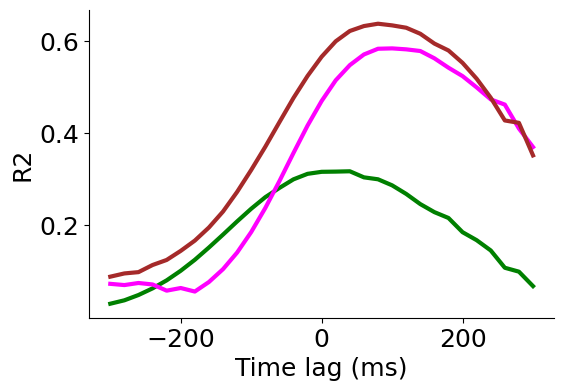

In [19]:
lw = 3
fig, ax = plt.subplots(figsize=(6,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.plot(lag_axis,cd_r2_array, label='CD',linewidth=lw,color='green')
print(np.max(cd_r2_array))
print(lag_axis[np.argmax(cd_r2_array)])
plt.plot(lag_axis,fb_r2_array, label='FB',linewidth=lw,color='magenta')
print(np.max(fb_r2_array))
print(lag_axis[np.argmax(fb_r2_array)])
plt.plot(lag_axis,cd_fb_r2_array, linewidth=lw,label='CD+FB',color='brown')
print(np.max(cd_fb_r2_array))
print(lag_axis[np.argmax(cd_fb_r2_array)])
plt.xlabel('Time lag (ms)')
plt.ylabel('R2')
# plt.legend()

0.20388660012963855
-20
0.5986059804406907
80
0.6253233903269566
100


Text(0, 0.5, 'X-R2')

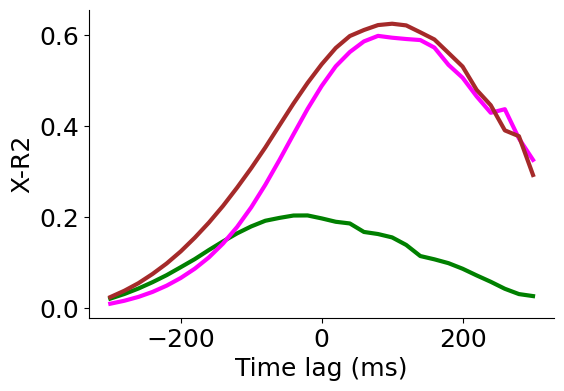

In [20]:
fig, ax = plt.subplots(figsize=(6,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.plot(lag_axis,cd_x_r2_array, linewidth=lw,label='CD',color='green')
print(np.max(cd_x_r2_array))
print(lag_axis[np.argmax(cd_x_r2_array)])
plt.plot(lag_axis,fb_x_r2_array, linewidth=lw,label='FB',color='magenta')
print(np.max(fb_x_r2_array))
print(lag_axis[np.argmax(fb_x_r2_array)])
plt.plot(lag_axis,cd_fb_x_r2_array, linewidth=lw,label='CD+FB',color='brown')
print(np.max(cd_fb_x_r2_array))
print(lag_axis[np.argmax(cd_fb_x_r2_array)])
plt.xlabel('Time lag (ms)')
plt.ylabel('X-R2')
# plt.legend()

0.44142667396930957
40
0.5733625069892192
100
0.6514479613101142
60


Text(0, 0.5, 'Y-R2')

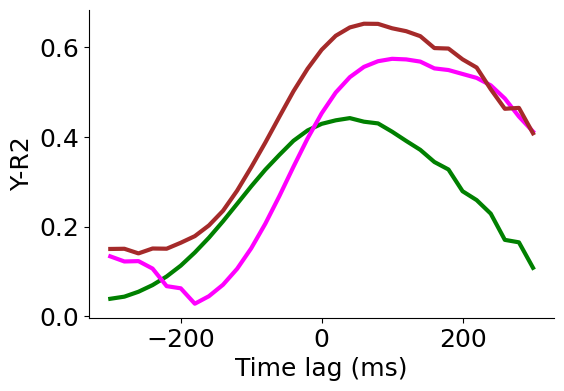

In [21]:
fig, ax = plt.subplots(figsize=(6,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.plot(lag_axis,cd_y_r2_array, linewidth=lw,label='CD',color='green')
print(np.max(cd_y_r2_array))
print(lag_axis[np.argmax(cd_y_r2_array)])
plt.plot(lag_axis,fb_y_r2_array,linewidth=lw,label='FB',color='magenta')
print(np.max(fb_y_r2_array))
print(lag_axis[np.argmax(fb_y_r2_array)])
plt.plot(lag_axis,cd_fb_y_r2_array, linewidth=lw,label='CD+FB',color='brown')
print(np.max(cd_fb_y_r2_array))
print(lag_axis[np.argmax(cd_fb_y_r2_array)])
plt.xlabel('Time lag (ms)')
plt.ylabel('Y-R2')
# plt.legend()

0.016153602183001103
-20
0.0927628986536504
0
0.09734671859541266
0


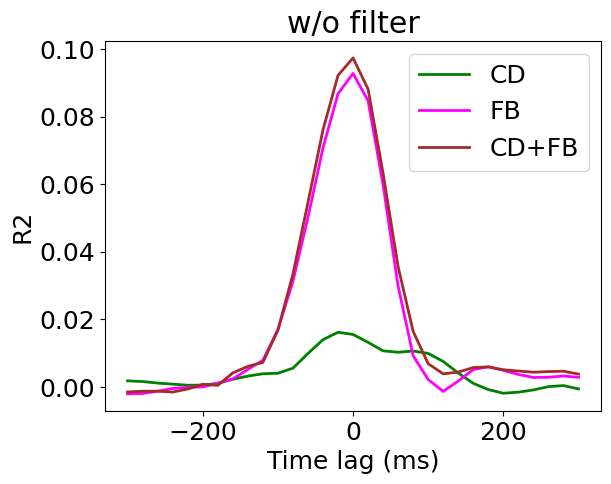

In [10]:
plt.plot(lag_axis,cd_r2_wo_filter_array, linewidth=lw,label='CD',color='green')
print(np.max(cd_r2_wo_filter_array))
print(lag_axis[np.argmax(cd_r2_wo_filter_array)])
plt.plot(lag_axis,fb_r2_wo_filter_array,linewidth=lw,label='FB',color='magenta')
print(np.max(fb_r2_wo_filter_array))
print(lag_axis[np.argmax(fb_r2_wo_filter_array)])
plt.plot(lag_axis,cd_fb_r2_wo_filter_array, linewidth=lw,label='CD+FB',color='brown')
print(np.max(cd_fb_r2_wo_filter_array))
print(lag_axis[np.argmax(cd_fb_r2_wo_filter_array)])
plt.title('w/o filter')
plt.xlabel('Time lag (ms)')
plt.ylabel('R2')
plt.legend()

#### Plot traces

In [28]:
dataset = dataset_10ms
x_field = 'CD_FB_proj'
y_field ='hand_vel'
lag_axis = np.arange(-300,320,20)
trial_mask = active_mask
cond_dict = active_cond_dict
# trial_mask = passive_mask
# cond_dict = passive_cond_dict

figDir = '/Users/sherryan/area2_population_analysis/figures_plus/PCA/'
dim = dataset_10ms.data[x_field].shape[1]
filter = True
filter_type='anti-causal'
init = None
pred_range = (-500, 1400)

In [ ]:
with np.load(monkey+'_'+x_field+'_'+y_field+'_'+filter_type+'_81filter'+'.npz', allow_pickle=True) as data:
    cd_fb_r2_array = data['r2_array']
    cd_fb_x_r2_array = data['x_r2_array']
    cd_fb_y_r2_array = data['y_r2_array']
    cd_fb_r_array = data['r_array']
    cd_fb_r2_wo_filter_array = data['r2_wo_filter_array']
    cd_fb_coef_array = data['coef_array']
    cd_fb_time_max = data['time_max']
    cd_fb_best_coef = data['best_coef']
    cd_fb_best_intercept = data['best_intercept']
    cd_fb_best_sigmas = data['best_sigmas']

In [30]:
# gaussian_x_r2_array = x_r2_array
# gaussian_y_r2_array = y_r2_array
# gaussian_r2_array = r2_array

# causal_x_r2_array = x_r2_array
# causal_y_r2_array = y_r2_array
# causal_r2_array = r2_array

anticausal_x_r2_array = x_r2_array
anticausal_y_r2_array = y_r2_array
anticausal_r2_array = r2_array

In [ ]:
for i in range(10):
    plt.plot(lag_axis,(np.sum(abs(coef_array[:,:,order[i]]),axis=1)),label = str(i+1))
plt.legend(fontsize=8)
plt.xlabel('Time lag (ms)')
plt.ylabel('Latent weight')
plt.title(x_field)
plt.show()
for i in range(10):
    plt.plot(lag_axis,np.sum(coef_array[:,:,order[i]],axis=1),label = str(i+1))
plt.legend(fontsize=8)
plt.xlabel('Time lag (ms)')
plt.ylabel('Latent weight')
plt.title(x_field)

In [ ]:
for i in range(10):
    plt.plot(lag_axis,abs(coef_array[:,0,order[i]]),label = str(i+1))
plt.legend(fontsize=8)
plt.xlabel('Time lag (ms)')
plt.ylabel('Latent weight')
plt.title(x_field+' x-dir')
plt.show()
for i in range(10):
    plt.plot(lag_axis,abs(coef_array[:,1,order[i]]),label = str(i+1))
plt.legend(fontsize=8)
plt.xlabel('Time lag (ms)')
plt.ylabel('Latent weight')
plt.title(x_field+' y-dir')

In [ ]:
print(time_max)
ldgf_best, vel_df, sigmas = retrieve_LDGF(dataset, trial_mask, 'move_onset_time',pred_range, time_max, x_field, y_field, cond_dict=cond_dict,filter=filter,filter_type=filter_type,init=init)

In [ ]:
# Prepare for plotting
plot_dir = [0.0, 90.0, 180.0, 270.0] # limit plot directions to reduce cluttering
colors = ['red', 'blue', 'green', 'orange']
plot_dim = 'x' # plot x velocity 

x_axis = np.arange(-500,1400,dataset.bin_width)
fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for trial_dir, color in zip(plot_dir, colors):
    cond_ids = dataset.trial_info[dataset.trial_info.cond_dir == trial_dir].trial_id
    for _, trial in vel_df[np.isin(vel_df.trial_id, cond_ids)].groupby('trial_id'):
        plt.plot(x_axis, trial[y_field][plot_dim], color=color, linewidth=0.5)
        # plt.plot(x_axis, trial[y_field].to_numpy()[:,0], color=color, linewidth=0.5)
plt.xlabel('Time after movement onset (ms)')
# plt.ylabel('Shoulder angle')
# plt.ylabel('Shoulder velocity')
# plt.ylabel('Muscle pc (au)')
# plt.ylabel('Hand position (cm)')
# plt.ylabel('Hand acceleration (cm/s^2)')
plt.ylabel('Hand velocity (cm/s)')

# plt.xlim([-100,500])
# plt.ylim([-0.65,0.65])
plt.tight_layout()
# plt.savefig(figDir + monkey + label + 'true.pdf', dpi = 'figure')
plt.show()

fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for trial_dir, color in zip(plot_dir, colors):
    cond_ids = dataset.trial_info[dataset.trial_info.cond_dir == trial_dir].trial_id
    for _, trial in vel_df[np.isin(vel_df.trial_id, cond_ids)].groupby('trial_id'):
         plt.plot(x_axis, trial['pred_vel'][plot_dim], color=color, linewidth=0.5)
        # plt.plot(x_axis, trial.pred_vel.to_numpy()[:,0], color=color, linewidth=0.5)
plt.xlabel('Time after movement onset (ms)')
# plt.ylabel('Shoulder angle')
# plt.ylabel('Shoulder velocity')
# plt.ylabel('Muscle pc (au)')
# plt.ylabel('Hand position (cm)')
# plt.ylabel('Hand acceleration (cm/s^2)')
plt.ylabel('Hand velocity  (cm/s)')
# plt.xlim([-100,500])
# plt.ylim([-0.65,0.65])
plt.tight_layout()
# plt.savefig(figDir + monkey + label + str(0) +'_pred.pdf', dpi = 'figure')
plt.show()

plot_dim = 'y' # plot y velocity 

fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for trial_dir, color in zip(plot_dir, colors):
    cond_ids = dataset.trial_info[dataset.trial_info.cond_dir == trial_dir].trial_id
    for _, trial in vel_df[np.isin(vel_df.trial_id, cond_ids)].groupby('trial_id'):
        plt.plot(x_axis, trial[y_field][plot_dim], color=color, linewidth=0.5)
        # plt.plot(x_axis, trial[y_field].to_numpy()[:,0], color=color, linewidth=0.5)
plt.xlabel('Time after movement onset (ms)')
# plt.ylabel('Shoulder angle')
# plt.ylabel('Shoulder velocity')
# plt.ylabel('Muscle pc (au)')
# plt.ylabel('Hand position (cm)')
# plt.ylabel('Hand acceleration (cm/s^2)')
plt.ylabel('Hand velocity (cm/s)')

# plt.xlim([-100,500])
# plt.ylim([-0.65,0.65])
plt.tight_layout()
# plt.savefig(figDir + monkey + label + 'true.pdf', dpi = 'figure')
plt.show()

fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for trial_dir, color in zip(plot_dir, colors):
    cond_ids = dataset.trial_info[dataset.trial_info.cond_dir == trial_dir].trial_id
    for _, trial in vel_df[np.isin(vel_df.trial_id, cond_ids)].groupby('trial_id'):
         plt.plot(x_axis, trial['pred_vel'][plot_dim], color=color, linewidth=0.5)
        # plt.plot(x_axis, trial.pred_vel.to_numpy()[:,0], color=color, linewidth=0.5)
plt.xlabel('Time after movement onset (ms)')
# plt.ylabel('Shoulder angle')
# plt.ylabel('Shoulder velocity')
# plt.ylabel('Muscle pc (au)')
# plt.ylabel('Hand position (cm)')
# plt.ylabel('Hand acceleration (cm/s^2)')
plt.ylabel('Hand velocity  (cm/s)')
# plt.xlim([-100,500])
# plt.ylim([-0.65,0.65])
plt.tight_layout()
# plt.savefig(figDir + monkey + label + str(0) +'_pred.pdf', dpi = 'figure')
plt.show()

fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.plot(lag_axis, x_r2_array,color = 'k')
plt.axvline(time_max, color = 'k', linestyle='--')
print(r2_array)
print(time_max)
# plt.title('R2 score predicting ' + y_field + ' ' + str(pred_range))
plt.xlabel('Time lag (ms)')
plt.ylabel('X R2')
# plt.ylim([0.00,0.5])
plt.tight_layout()
# plt.savefig(figDir + monkey +'_acc_' + str(0) +'.pdf', dpi = 'figure')
plt.show()

fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.plot(lag_axis, y_r2_array,color = 'k')
plt.axvline(time_max, color = 'k', linestyle='--')
print(r2_array)
print(time_max)
# plt.title('R2 score predicting ' + y_field + ' ' + str(pred_range))
plt.xlabel('Time lag (ms)')
plt.ylabel('Y R2')
# plt.ylim([0.00,0.5])
plt.tight_layout()
# plt.savefig(figDir + monkey +'_acc_' + str(0) +'.pdf', dpi = 'figure')
plt.show()


fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.plot(lag_axis, r2_array,color = 'k')
plt.axvline(time_max, color = 'k', linestyle='--')
print(r2_array)
print(time_max)
# plt.title('R2 score predicting ' + y_field + ' ' + str(pred_range))
plt.xlabel('Time lag (ms)')
plt.ylabel('R2')
# plt.ylim([0.00,0.5])
plt.tight_layout()
# plt.savefig(figDir + monkey +'_acc_' + str(0) +'.pdf', dpi = 'figure')
plt.show()

fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.plot(lag_axis, r2_wo_filter_array,color = 'k')
plt.axvline(time_max, color = 'k', linestyle='--')
print(r2_wo_filter_array)
print(time_max)
# plt.title('R2 score predicting ' + y_field + ' ' + str(pred_range))
plt.xlabel('Time lag (ms)')
plt.ylabel('R2_neuro')
# plt.ylim([0.00,0.5])
plt.tight_layout()
# plt.savefig(figDir + monkey +'_acc_' + str(0) +'.pdf', dpi = 'figure')
plt.show()


fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.plot(lag_axis, r_array,color = 'k')
plt.axvline(time_max, color = 'k', linestyle='--')
print(time_max)
plt.xlabel('Time lag (ms)')
plt.ylabel('r')
# plt.ylim([0.05,0.8])
plt.tight_layout()
# plt.savefig(figDir + monkey +'_vel_' + str(0) +'.pdf', dpi = 'figure')
plt.show()

idx_max_pos = np.argwhere(r2_array == np.max(r2_array[np.argwhere(lag_axis==0)[0,0]:]))[0,0]
idx_max_neg = np.argwhere(r2_array == np.max(r2_array[:np.argwhere(lag_axis==0)[0,0]]))[0,0]
print(lag_axis[idx_max_pos])
print(lag_axis[idx_max_neg])

#For velocity, override max identification
# idx_max_pos = np.argwhere(lag_axis==80)[0,0]
# idx_max_neg = np.argwhere(lag_axis==-40)[0,0]

ang_to_max_x = nans([len(lag_axis)])
ang_to_max_y = nans([len(lag_axis)])
# ang_to_max_z = nans([len(lag_axis)])
for i in range(0, len(coef_array)):
    ang_to_max_x[i] = math.degrees(angle_between(coef_array[i,0,:],coef_array[idx_max_neg,0,:]))
    ang_to_max_y[i] = math.degrees(angle_between(coef_array[i,1,:],coef_array[idx_max_neg,1,:]))
    # ang_to_max_z[i] = math.degrees(angle_between(coef_array[i,2,:],coef_array[idx_max_neg,2,:]))
fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.ylim([-5, 130])
plt.xlim([-310, 310])
plt.scatter(lag_axis, ang_to_max_x,label = 'x',color = 'green')
plt.scatter(lag_axis, ang_to_max_y,label = 'y',color = 'blue')
# plt.scatter(lag_axis, ang_to_max_z,label = 'wrist_abduction',color = 'orange')

plt.legend()
plt.xlabel('Time lag (ms)')
plt.ylabel('Angle (degrees)')
mean = np.mean([ang_to_max_x[idx_max_pos], ang_to_max_y[idx_max_pos]])
print(mean)
# plt.vlines(lag_axis[idx_max_pos],-5, mean, color = 'k',linestyle="dashed")
# plt.hlines(mean, -310, lag_axis[idx_max_pos], color = 'k',linestyle="dashed")
plt.tight_layout()
# plt.savefig(figDir + monkey + label + str(0) +'_angle.pdf', dpi = 'figure')
plt.show()



In [ ]:
plt.plot(lag_axis,gaussian_r2_array, label='gaussian')
print(np.max(gaussian_r2_array))
print(lag_axis[np.argmax(gaussian_r2_array)])
plt.plot(lag_axis,causal_r2_array, label='causal')
print(np.max(causal_r2_array))
print(lag_axis[np.argmax(causal_r2_array)])
plt.plot(lag_axis,anticausal_r2_array, label='anti-causal')
print(np.max(anticausal_r2_array))
print(lag_axis[np.argmax(anticausal_r2_array)])
plt.xlabel('Time lag (ms)')
plt.ylabel('R2')
plt.legend()

In [ ]:
plt.plot(lag_axis,gaussian_x_r2_array, label='gaussian')
print(np.max(gaussian_x_r2_array))
print(lag_axis[np.argmax(gaussian_x_r2_array)])
plt.plot(lag_axis,causal_x_r2_array, label='causal')
print(np.max(causal_x_r2_array))
print(lag_axis[np.argmax(causal_x_r2_array)])
plt.plot(lag_axis,anticausal_x_r2_array, label='anti-causal')
print(np.max(anticausal_x_r2_array))
print(lag_axis[np.argmax(anticausal_x_r2_array)])
plt.xlabel('Time lag (ms)')
plt.ylabel('X R2')
plt.legend()

In [ ]:
plt.plot(lag_axis,gaussian_y_r2_array, label='gaussian')
print(np.max(gaussian_y_r2_array))
print(lag_axis[np.argmax(gaussian_y_r2_array)])
plt.plot(lag_axis,causal_y_r2_array, label='causal')
print(np.max(causal_y_r2_array))
print(lag_axis[np.argmax(causal_y_r2_array)])
plt.plot(lag_axis,anticausal_y_r2_array, label='anti-causal')
print(np.max(anticausal_y_r2_array))
print(lag_axis[np.argmax(anticausal_y_r2_array)])
plt.xlabel('Time lag (ms)')
plt.ylabel('Y R2')
plt.legend()

### Cross-decoding

In [11]:
foldername = "~/area2_population_analysis/s1-kinematics/actpas_NWB/"
# monkey = "Han_20171207"
# filename = foldername + monkey + "_COactpas_TD_offset4.nwb"

monkey = 'Duncan_20190710'
filename = foldername + monkey + "_COactpas_offset4.nwb"

dataset_10ms = NWBDataset(filename, split_heldout=False)
dataset_10ms.resample(10) #in 10-ms bin, has to resample first to avoid NaNs
bin_width = dataset_10ms.bin_width
print(bin_width)

10


In [12]:
x_field = 'spikes'
data = np.load(monkey+'_v4_unsmoothed100_cdfb_data_'+x_field+'.npz')
data.files
dataset_10ms.add_continuous_data(data['CD_FB_proj'],'CD_FB_proj')
dataset_10ms.add_continuous_data(data['CD_proj'],'CD_proj')
dataset_10ms.add_continuous_data(data['FB_proj'],'FB_proj')
dataset_10ms.data.keys().unique(0)

Index(['force', 'hand_pos', 'hand_vel', 'spikes', 'CD_FB_proj', 'CD_proj',
       'FB_proj'],
      dtype='object', name='signal_type')

In [13]:
n_trials = dataset_10ms.trial_info.shape[0]
print(n_trials,'total trials')
n_neurons = dataset_10ms.data.spikes.shape[1]
print(n_neurons,'neurons')

#make dictionary for trial condition (reaching directions) for Stratified CV
dataset = dataset_10ms
active_mask = (dataset.trial_info.ctr_hold_bump==0) & (dataset.trial_info['split'] != 'none')
passive_mask = (dataset.trial_info.ctr_hold_bump==1) & (dataset.trial_info['split'] != 'none')
nan_mask = (np.isnan(dataset.trial_info.ctr_hold_bump)) & (dataset.trial_info['split'] != 'none')
all_mask = (dataset.trial_info['split'] != 'none')

trial_mask = all_mask
valid_n_trials = dataset.trial_info.loc[trial_mask].shape[0]
print(valid_n_trials,'valid trials')

trial_mask = active_mask
active_trials_idx = np.array(dataset.trial_info.loc[trial_mask]['trial_id'])
active_n_trials = dataset.trial_info.loc[trial_mask].shape[0]
print(active_n_trials,'active trials')

trial_mask = passive_mask
passive_trials_idx = np.array(dataset.trial_info.loc[trial_mask]['trial_id'])
passive_n_trials = dataset.trial_info.loc[trial_mask].shape[0]
print(passive_n_trials,'passive trials')

trial_mask = nan_mask
nan_trials_idx = np.array(dataset.trial_info.loc[trial_mask]['trial_id'])
nan_n_trials = dataset.trial_info.loc[trial_mask].shape[0]
print(nan_n_trials,'reach bump trials')

active_cond_dir_idx = []
passive_cond_dir_idx = []
nan_cond_dir_idx = []
nan_bump_cond_dir_idx = []
for direction in [0,45,90,135,180,225,270,315]:
# for direction in [0,90,180,270]:
    active_cond_dir_idx.append(np.where((dataset.trial_info['cond_dir']%360 == direction) & (dataset.trial_info['ctr_hold_bump'] == 0) & \
           (dataset.trial_info['split'] != 'none'))[0])
    passive_cond_dir_idx.append(np.where((dataset.trial_info['cond_dir']%360 == direction) & (dataset.trial_info['ctr_hold_bump'] == 1) & \
           (dataset.trial_info['split'] != 'none'))[0])
    nan_cond_dir_idx.append(np.where((dataset.trial_info['cond_dir']%360 == direction) & (np.isnan(dataset.trial_info.ctr_hold_bump)) & \
           (dataset.trial_info['split'] != 'none'))[0])
    nan_bump_cond_dir_idx.append(np.where((dataset.trial_info['bump_dir']%360 == direction) & (np.isnan(dataset.trial_info.ctr_hold_bump)) & \
           (dataset.trial_info['split'] != 'none'))[0])

active_cond_dict = nans([active_n_trials])
i = 0
for idx in active_trials_idx:
    for cond in range(0,len(active_cond_dir_idx)):
        if idx in active_cond_dir_idx[cond]:
            active_cond_dict[i] = cond
            break
    i+=1
print(active_cond_dict)
print(len(active_cond_dict))

passive_cond_dict = nans([passive_n_trials])
i = 0
for idx in passive_trials_idx:
    for cond in range(0,len(passive_cond_dir_idx)):
        if idx in passive_cond_dir_idx[cond]:
            passive_cond_dict[i] = cond
            break
    i+=1
print(passive_cond_dict)
print(len(passive_cond_dict))

nan_cond_dict = nans([nan_n_trials])
i = 0
for idx in nan_trials_idx:
    for cond in range(0,len(nan_cond_dir_idx)):
        if idx in nan_cond_dir_idx[cond]:
            nan_cond_dict[i] = cond
            break
    i+=1
print(nan_cond_dict)
print(len(nan_cond_dict))

nan_bump_cond_dict = nans([nan_n_trials])
i = 0
for idx in nan_trials_idx:
    for cond in range(0,len(nan_bump_cond_dir_idx)):
        if idx in nan_bump_cond_dir_idx[cond]:
            nan_bump_cond_dict[i] = cond
            break
    i+=1
print(nan_bump_cond_dict)
print(len(nan_bump_cond_dict))

if monkey =='Duncan_20190710':
    active_df = dataset_10ms.make_trial_data(align_field='move_onset_time', align_range = (-100,100), ignored_trials = ~active_mask)
    del_indices = list(set(active_trials_idx) - set(active_df['trial_id'].unique()))
    print('was',active_n_trials,'active trials')
    active_n_trials = active_n_trials - len(list(set(active_trials_idx) - set(active_df['trial_id'].unique())))
    active_cond_dict = np.delete(active_cond_dict,np.argwhere(active_trials_idx==del_indices)[0])
    print('now',active_n_trials,'active trials')
    print(len(active_cond_dict))

1450 total trials
176 neurons
1212 valid trials
624 active trials
308 passive trials
280 reach bump trials
[4. 6. 1. 7. 1. 4. 5. 2. 4. 7. 4. 0. 1. 3. 0. 7. 6. 6. 1. 1. 0. 2. 5. 4.
 1. 1. 6. 6. 0. 3. 2. 2. 6. 6. 5. 3. 1. 5. 0. 0. 0. 3. 3. 1. 2. 6. 2. 5.
 6. 7. 1. 6. 1. 4. 0. 1. 1. 1. 7. 0. 4. 2. 4. 0. 0. 3. 3. 2. 4. 3. 6. 0.
 4. 2. 6. 1. 1. 1. 0. 6. 1. 0. 1. 4. 2. 5. 5. 7. 2. 6. 5. 0. 7. 7. 7. 0.
 7. 4. 2. 7. 7. 1. 7. 7. 0. 1. 5. 1. 2. 0. 4. 1. 4. 1. 2. 0. 1. 4. 1. 6.
 1. 0. 4. 3. 4. 5. 4. 4. 2. 7. 2. 0. 2. 6. 5. 2. 3. 5. 3. 3. 6. 0. 0. 7.
 4. 5. 7. 0. 4. 5. 0. 6. 4. 5. 7. 1. 4. 7. 2. 6. 7. 3. 0. 6. 4. 1. 1. 7.
 6. 5. 3. 3. 4. 5. 7. 2. 3. 6. 2. 5. 1. 3. 3. 4. 1. 7. 6. 6. 4. 0. 3. 7.
 4. 6. 5. 7. 5. 3. 1. 7. 6. 6. 2. 0. 1. 4. 4. 1. 7. 6. 3. 1. 3. 1. 6. 1.
 5. 5. 6. 4. 0. 6. 2. 0. 1. 7. 0. 5. 7. 0. 5. 4. 0. 7. 7. 4. 6. 7. 2. 0.
 0. 2. 0. 0. 0. 2. 7. 7. 7. 6. 2. 2. 7. 3. 4. 5. 6. 7. 3. 0. 4. 7. 2. 7.
 2. 7. 1. 2. 2. 2. 1. 2. 6. 6. 7. 3. 5. 7. 6. 1. 1. 0. 6. 6. 0. 4. 0. 1.
 2. 0. 7. 3. 1. 1

In [33]:
filter_type = 'gaussian'
lag_axis = np.arange(-300,320,20)

foldername = "/Users/sherryan/area2_population_analysis/"

x_field = 'CD_FB_proj'
y_field ='hand_vel'
with np.load(foldername+monkey+'_'+x_field+'_'+y_field+'_'+filter_type+'_81filter_100_v4'+'.npz', allow_pickle=True) as data:
    cd_fb_best_coef = data['best_coef']
    cd_fb_best_intercept = data['best_intercept']
    cd_fb_best_sigmas = data['best_sigmas']
    cd_fb_time_max = data['time_max']

x_field = 'CD_proj'
y_field ='hand_vel'
with np.load(foldername+monkey+'_'+x_field+'_'+y_field+'_'+filter_type+'_81filter_100_v4'+'.npz', allow_pickle=True) as data:
    cd_best_coef = data['best_coef']
    cd_best_intercept = data['best_intercept']
    cd_best_sigmas = data['best_sigmas']
    cd_time_max = data['time_max']

x_field = 'FB_proj'
y_field ='hand_vel'
with np.load(foldername+monkey+'_'+x_field+'_'+y_field+'_'+filter_type+'_81filter_100_v4'+'.npz', allow_pickle=True) as data:
    fb_best_coef = data['best_coef']
    fb_best_intercept = data['best_intercept']
    fb_best_sigmas = data['best_sigmas']
    fb_time_max = data['time_max']

In [25]:
import pandas as pd
from scipy.signal import convolve
import scipy
def pred_with_new_LDGF(dataset, filter_type, trial_mask, align_field, align_range, lag, x_field, y_field, weights, offset, sigmas, train_align_field, train_range, train_best_lag, train_mask,filter_length=81):
    def gaussian_filter(x, sigma,filter_length):
        return np.exp(-0.5*((x)/sigma)**2)
    def causal_filter(x, sigma,filter_length):
        phi_x = np.exp(-0.5*((x)/sigma)**2)
        phi_x[:filter_length//2] = 0
        return phi_x
    def anticausal_filter(x, sigma,filter_length):
        phi_x = np.exp(-0.5*((x)/sigma)**2)
        phi_x[-filter_length//2+1:] = 0
        return phi_x
    x_range = np.arange(-filter_length//2+1, filter_length//2+1)
    """ Returns R2, r, and predictions using given weights, basically a matrix multiplication """
    vel_df = dataset.make_trial_data(align_field=align_field, align_range=align_range, ignored_trials=~trial_mask)

    lag_align_range = (align_range[0] + lag, align_range[1] + lag)
    rates_df = dataset.make_trial_data(align_field=align_field, align_range=lag_align_range, ignored_trials=~trial_mask)
    n_trials = rates_df['trial_id'].nunique()
    n_timepoints = int((align_range[1] - align_range[0])/dataset.bin_width)

    rates_array = rates_df[x_field].to_numpy()
    vel_array = vel_df[y_field].to_numpy()

    train_lag_range = (train_range[0] + train_best_lag, train_range[1] + train_best_lag)
    train_rates_df = dataset.make_trial_data(align_field=train_align_field, align_range=train_lag_range, ignored_trials=~train_mask, allow_overlap=True)
    train_rates_array = train_rates_df[x_field].to_numpy()

    X = (rates_array - np.nanmean(train_rates_array,axis=0))/np.nanstd(train_rates_array,axis=0)
    Y_hat = X@weights.T + offset
    Y_hat_reshaped = Y_hat.reshape(n_trials, n_timepoints, vel_array.shape[-1])

    if filter_type == 'causal':
        filter_list = [causal_filter(x_range,sigmas[j],filter_length) for j in range(len(sigmas))]
    elif filter_type == 'gaussian':
        filter_list = [gaussian_filter(x_range,sigmas[j],filter_length) for j in range(len(sigmas))]
    elif filter_type == 'anti-causal':
        filter_list = [anticausal_filter(x_range,sigmas[j],filter_length) for j in range(len(sigmas))]
    else:
        print('error: filter type not specified')
        return
    
    Y_hat_with_filter = np.array([np.apply_along_axis(convolve, 1, Y_hat_reshaped[:,:,j], filter, mode='same') for j, filter in enumerate(filter_list)]).transpose(1, 2, 0)


    train_vel_df = dataset.make_trial_data(align_field=train_align_field, align_range=train_range, ignored_trials=~train_mask, allow_overlap=True)
    train_vel_array = train_vel_df[y_field].to_numpy()
    Y_hat_trunc = Y_hat_with_filter[:,filter_length//2:-filter_length//2+1,:]
    y_pred = (Y_hat_trunc + np.nanmean(train_vel_array,axis=0))
    pred_vel = y_pred.reshape(-1, vel_array.shape[-1])

    y = vel_array.reshape(n_trials, n_timepoints, -1)
    y_trunc = y[:,filter_length//2:-filter_length//2+1,:] #match valid size
    true_vel = y_trunc.reshape(-1, vel_array.shape[-1])
            
    R2_array = nans([true_vel.shape[1]])
    for i in range(true_vel.shape[1]):
        sses =get_sses_pred(true_vel[:,i],pred_vel[:,i])
        sses_mean=get_sses_mean(true_vel[:,i])
        R2_array[i] =1-np.sum(sses)/np.sum(sses_mean)    

    
    sses =get_sses_pred(true_vel,pred_vel)
    sses_mean=get_sses_mean(true_vel)
    R2 =1-np.sum(sses)/np.sum(sses_mean)     
    
    r = scipy.stats.pearsonr(true_vel.reshape(-1), pred_vel.reshape(-1))[0]
    
    if vel_array.shape[-1] == 2:
        vel_df = pd.concat([vel_df, pd.DataFrame(pred_vel, columns=dataset._make_midx('pred_vel', ['x', 'y'], 2))], axis=1)
    elif vel_array.shape[-1] == 3:
        vel_df = pd.concat([vel_df, pd.DataFrame(pred_vel, columns=dataset._make_midx('pred_vel', ['x', 'y','z'], 3))], axis=1)
    else:
        vel_df = pd.concat([vel_df, pd.DataFrame(pred_vel, columns=dataset._make_midx('pred_vel', num_channels=vel_array.shape[-1]))], axis=1)
    
    return R2, r, R2_array, vel_df

In [34]:
dataset = dataset_10ms
x_field = 'CD_proj'
y_field ='hand_vel'
n_features = 2
lag_axis = np.arange(-300,320,20)
trial_mask = passive_mask
cond_dict = passive_cond_dict
best_coef = cd_best_coef
best_offset = cd_best_intercept
best_sigmas = cd_best_sigmas
best_lag = cd_time_max.flatten()[0]
dim = dataset_10ms.data[x_field].shape[1]
print(dim)

pred_range = (-500, 520)
cd_time_max = nans([len(lag_axis)]); 
cd_r2_array = nans([len(lag_axis)]);
cd_x_r2_array = nans([len(lag_axis)]); cd_y_r2_array = nans([len(lag_axis)])
cd_r_array = nans([len(lag_axis)])

if filter:
    for i in range(len(lag_axis)):
        lag = lag_axis[i]
        # print(lag)
        r2, r, r2_arr, vel_df = pred_with_new_LDGF(dataset, filter_type,trial_mask, 'move_onset_time', pred_range, lag, x_field, y_field, best_coef, best_offset, best_sigmas, 'move_onset_time', (-500, 1500), best_lag, active_mask)
        cd_r2_array[i] = r2; 
        # r2_wo_filter_array[i] = r2_wo
        cd_x_r2_array[i] = r2_arr[0]; cd_y_r2_array[i] = r2_arr[1]
        cd_r_array[i] = r
        # print('R2=',r2)
    cd_time_max = lag_axis[np.argmax(cd_time_max)]
    print(np.max(cd_r2_array))


4


Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 

-0.24053606045194953


In [35]:
dataset = dataset_10ms
x_field = 'FB_proj'
y_field ='hand_vel'
n_features = 2
lag_axis = np.arange(-300,320,20)
trial_mask = passive_mask
cond_dict = passive_cond_dict
best_coef = fb_best_coef
best_offset = fb_best_intercept
best_sigmas = fb_best_sigmas
best_lag = fb_time_max.flatten()[0]
dim = dataset_10ms.data[x_field].shape[1]
print(dim)

pred_range = (-500, 520)
fb_time_max = nans([len(lag_axis)]); 
fb_r2_array = nans([len(lag_axis)]);
fb_x_r2_array = nans([len(lag_axis)]); fb_y_r2_array = nans([len(lag_axis)])
fb_r_array = nans([len(lag_axis)])

if filter:
    for i in range(len(lag_axis)):
        lag = lag_axis[i]
        # print(lag)
        r2, r, r2_arr, vel_df = pred_with_new_LDGF(dataset, filter_type,trial_mask, 'move_onset_time', pred_range, lag, x_field, y_field, best_coef, best_offset, best_sigmas, 'move_onset_time', (-500, 1500), best_lag, active_mask)
        fb_r2_array[i] = r2; 
        # r2_wo_filter_array[i] = r2_wo
        fb_x_r2_array[i] = r2_arr[0]; fb_y_r2_array[i] = r2_arr[1]
        fb_r_array[i] = r
        # print('R2=',r2)
    fb_time_max = lag_axis[np.argmax(fb_time_max)]
    print(np.max(fb_r2_array))



7


Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 

0.4049592185736246


In [36]:
dataset = dataset_10ms
x_field = 'CD_FB_proj'
y_field ='hand_vel'
n_features = 2
lag_axis = np.arange(-300,320,20)
trial_mask = passive_mask
cond_dict = passive_cond_dict
best_coef = cd_fb_best_coef
best_offset = cd_fb_best_intercept
best_sigmas = cd_fb_best_sigmas
best_lag = cd_fb_time_max.flatten()[0]
dim = dataset_10ms.data[x_field].shape[1]
print(dim)

pred_range = (-500, 520)
cd_fb_time_max = nans([len(lag_axis)]); 
cd_fb_r2_array = nans([len(lag_axis)]);
cd_fb_x_r2_array = nans([len(lag_axis)]); cd_fb_y_r2_array = nans([len(lag_axis)])
cd_fb_r_array = nans([len(lag_axis)])

if filter:
    for i in range(len(lag_axis)):
        lag = lag_axis[i]
        # print(lag)
        r2, r, r2_arr, vel_df = pred_with_new_LDGF(dataset, filter_type,trial_mask, 'move_onset_time', pred_range, lag, x_field, y_field, best_coef, best_offset, best_sigmas, 'move_onset_time', (-500, 1500), best_lag, active_mask)
        cd_fb_r2_array[i] = r2; 
        # r2_wo_filter_array[i] = r2_wo
        cd_fb_x_r2_array[i] = r2_arr[0]; cd_fb_y_r2_array[i] = r2_arr[1]
        cd_fb_r_array[i] = r
        # print('R2=',r2)
    cd_fb_time_max = lag_axis[np.argmax(cd_fb_time_max)]
    print(np.max(cd_fb_r2_array))



11


Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 158 overlapping trials.
Allowed 

0.43161855676481964


In [37]:
np.savez(monkey+'_'+x_field+'_cdfb_'+filter_type+'_81filter_Xpas_v4', cd_r2_array = cd_r2_array, cd_x_r2_array = cd_x_r2_array, cd_y_r2_array = cd_y_r2_array, cd_r_array = cd_r_array, cd_time_max = cd_time_max,\
        fb_r2_array = fb_r2_array, fb_x_r2_array = fb_x_r2_array, fb_y_r2_array = fb_y_r2_array, fb_r_array = fb_r_array, fb_time_max = fb_time_max,\
        cd_fb_r2_array = cd_fb_r2_array, cd_fb_x_r2_array = cd_fb_x_r2_array, cd_fb_y_r2_array = cd_fb_y_r2_array, cd_fb_r_array = cd_fb_r_array, cd_fb_time_max = cd_fb_time_max)

-0.24053606045194953
-160
0.4049592185736246
-20
0.43161855676481964
-20


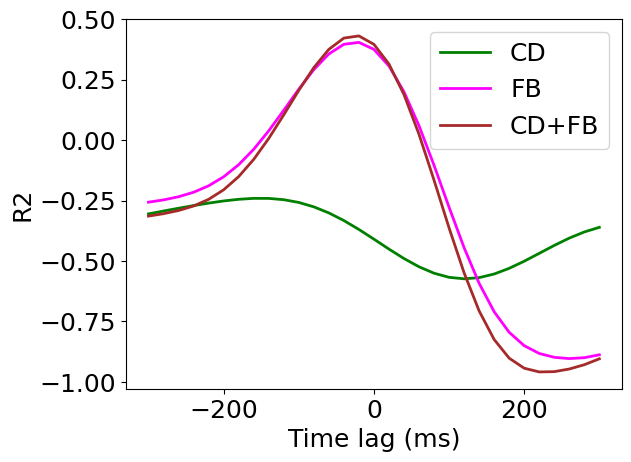

In [38]:
lw = 2
plt.plot(lag_axis,cd_r2_array, label='CD',linewidth=lw,color='green')
print(np.max(cd_r2_array))
print(lag_axis[np.argmax(cd_r2_array)])
plt.plot(lag_axis,fb_r2_array, label='FB',linewidth=lw,color='magenta')
print(np.max(fb_r2_array))
print(lag_axis[np.argmax(fb_r2_array)])
plt.plot(lag_axis,cd_fb_r2_array, linewidth=lw,label='CD+FB',color='brown')
print(np.max(cd_fb_r2_array))
print(lag_axis[np.argmax(cd_fb_r2_array)])
plt.xlabel('Time lag (ms)')
plt.ylabel('R2')
plt.legend()

-0.13939814144674778
-300
0.40659870550737587
-20
0.4378771852865996
-20


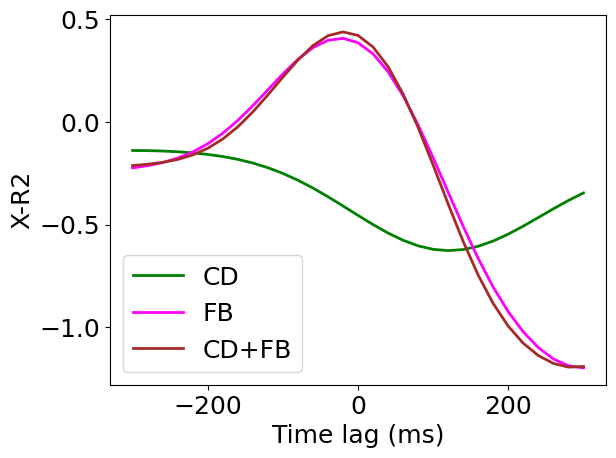

In [39]:
plt.plot(lag_axis,cd_x_r2_array, linewidth=lw,label='CD',color='green')
print(np.max(cd_x_r2_array))
print(lag_axis[np.argmax(cd_x_r2_array)])
plt.plot(lag_axis,fb_x_r2_array, linewidth=lw,label='FB',color='magenta')
print(np.max(fb_x_r2_array))
print(lag_axis[np.argmax(fb_x_r2_array)])
plt.plot(lag_axis,cd_fb_x_r2_array, linewidth=lw,label='CD+FB',color='brown')
print(np.max(cd_fb_x_r2_array))
print(lag_axis[np.argmax(cd_fb_x_r2_array)])
plt.xlabel('Time lag (ms)')
plt.ylabel('X-R2')
plt.legend()

-0.2572729531533
-60
0.4016420978493134
-20
0.42916517382995256
-40


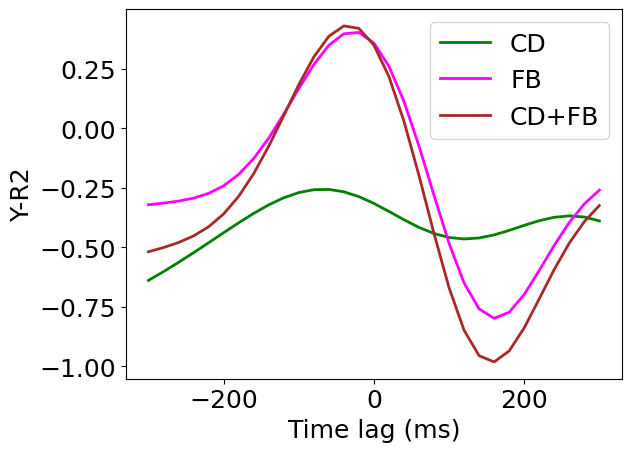

In [40]:
plt.plot(lag_axis,cd_y_r2_array, linewidth=lw,label='CD',color='green')
print(np.max(cd_y_r2_array))
print(lag_axis[np.argmax(cd_y_r2_array)])
plt.plot(lag_axis,fb_y_r2_array,linewidth=lw,label='FB',color='magenta')
print(np.max(fb_y_r2_array))
print(lag_axis[np.argmax(fb_y_r2_array)])
plt.plot(lag_axis,cd_fb_y_r2_array, linewidth=lw,label='CD+FB',color='brown')
print(np.max(cd_fb_y_r2_array))
print(lag_axis[np.argmax(cd_fb_y_r2_array)])
plt.xlabel('Time lag (ms)')
plt.ylabel('Y-R2')
plt.legend()

### Project out

In [ ]:
dataset = dataset_10ms
x_field = 'SCA'
y_field ='hand_vel'
lag_axis = np.arange(-300,320,20)
trial_mask = active_mask
cond_dict = active_cond_dict
# trial_mask = passive_mask
# cond_dict = passive_cond_dict

dim = n_dims
filter = True
init = None
pred_range = (-100, 1000)

with np.load(monkey+'_'+x_field+'_'+y_field+'_filter'+'.npz', allow_pickle=True) as data:
    r2_array = data['r2_array']
    x_r2_array = data['x_r2_array']
    y_r2_array = data['y_r2_array']
    r_array = data['r_array']
    r2_wo_filter_array = data['r2_wo_filter_array']
    coef_array = data['coef_array']
    ldgf_best = data['ldgf_best']
    time_max = data['time_max']
    best_coef = data['best_coef']
    best_intercept = data['best_intercept']

In [ ]:
import scipy.stats
filter = True
init = None
pred_range = (-100, 1000)
r2_array_sub = nans([len(lag_axis)]); r2_wo_filter_array_sub = nans([len(lag_axis)]); 
x_r2_array_sub = nans([len(lag_axis)]); y_r2_array_sub = nans([len(lag_axis)])
r_array_sub = nans([len(lag_axis)])
coef_array_sub = nans([len(lag_axis),2,dim])
if filter:
    for i in range(len(lag_axis)):
        lag = lag_axis[i]
        r2, r2_wo, ldgf, vel_df, x_r2, y_r2 = sub_and_predict_LDGF(dataset, trial_mask, 'move_onset_time',pred_range, lag, x_field, y_field, best_coef, cond_dict=cond_dict,filter=filter,init=init)
        coef,bias = ldgf.params['weight'],ldgf.params['bias']
        r2_array_sub[i] = r2; r2_wo_filter_array_sub[i] = r2_wo
        x_r2_array_sub[i] = x_r2; y_r2_array_sub[i] = y_r2
        r = scipy.stats.pearsonr(vel_df[y_field].to_numpy().reshape(-1), vel_df['pred_vel'].to_numpy().reshape(-1))[0]
        r_array_sub[i] = r
        coef_array_sub[i,:,:] = coef
    time_max_sub = lag_axis[np.argmax(r2_array_sub)]
    print(np.max(r2_array_sub))
    _, _, ldgf_best_sub, _, _, _ = sub_and_predict_LDGF(dataset, trial_mask, 'move_onset_time',pred_range, lag, x_field, y_field, best_coef,cond_dict=cond_dict,filter=filter,init=init)
    best_coef_sub,best_intercept_sub = ldgf_best_sub.params['weight'], ldgf_best_sub.params['bias']
    np.savez(monkey+'_'+x_field+'_'+y_field +'_filter_sub', r2_array_sub = r2_array_sub, r2_wo_filter_array_sub = r2_wo_filter_array_sub, x_r2_array_sub = x_r2_array_sub, y_r2_array_sub = y_r2_array_sub, r_array_sub = r_array_sub,\
         coef_array_sub = coef_array_sub, ldgf_best_sub = ldgf_best_sub, time_max = time_max, time_max_sub = time_max_sub, best_coef = best_coef, best_coef_sub = best_coef_sub, best_intercept_sub = best_intercept_sub) 

In [ ]:
dataset = dataset_10ms
x_field = 'spikes'
y_field ='hand_acc'
lag_axis = np.arange(-300,320,20)
trial_mask = active_mask
cond_dict = active_cond_dict
# trial_mask = passive_mask
# cond_dict = passive_cond_dict

figDir = '/Users/sherryan/area2_population_analysis/figures_plus/PCA/'
dim = n_neurons
filter = True
init = None
pred_range = (-100, 1000)

with np.load(monkey+'_'+x_field+'_'+y_field+'_filter'+'.npz', allow_pickle=True) as data:
    r2_array = data['r2_array']
    x_r2_array = data['x_r2_array']
    y_r2_array = data['y_r2_array']
    r_array = data['r_array']
    r2_wo_filter_array = data['r2_wo_filter_array']
    coef_array = data['coef_array']
    ldgf_best = data['ldgf_best']
    time_max = data['time_max']
    best_coef = data['best_coef']
    best_intercept = data['best_intercept']

In [ ]:
import scipy.stats
filter = True
init = None
pred_range = (-100, 1000)
r2_array_sub = nans([len(lag_axis)]); r2_wo_filter_array_sub = nans([len(lag_axis)]); 
x_r2_array_sub = nans([len(lag_axis)]); y_r2_array_sub = nans([len(lag_axis)])
r_array_sub = nans([len(lag_axis)])
coef_array_sub = nans([len(lag_axis),2,dim])
if filter:
    for i in range(len(lag_axis)):
        lag = lag_axis[i]
        r2, r2_wo, ldgf, vel_df, x_r2, y_r2 = sub_and_predict_LDGF(dataset, trial_mask, 'move_onset_time',pred_range, lag, x_field, y_field, best_coef, cond_dict=cond_dict,filter=filter,init=init)
        coef,bias = ldgf.params['weight'],ldgf.params['bias']
        r2_array_sub[i] = r2; r2_wo_filter_array_sub[i] = r2_wo
        x_r2_array_sub[i] = x_r2; y_r2_array_sub[i] = y_r2
        r = scipy.stats.pearsonr(vel_df[y_field].to_numpy().reshape(-1), vel_df['pred_vel'].to_numpy().reshape(-1))[0]
        r_array_sub[i] = r
        coef_array_sub[i,:,:] = coef
    time_max_sub = lag_axis[np.argmax(r2_array_sub)]
    print(np.max(r2_array_sub))
    _, _, ldgf_best_sub, _, _, _ = sub_and_predict_LDGF(dataset, trial_mask, 'move_onset_time',pred_range, lag, x_field, y_field, best_coef,cond_dict=cond_dict,filter=filter,init=init)
    best_coef_sub,best_intercept_sub = ldgf_best_sub.params['weight'], ldgf_best_sub.params['bias']
    np.savez(monkey+'_'+x_field+'_'+y_field +'_filter_sub', r2_array_sub = r2_array_sub, r2_wo_filter_array_sub =r2_wo_filter_array_sub, x_r2_array_sub = x_r2_array_sub, y_r2_array_sub = y_r2_array_sub, r_array_sub = r_array_sub,\
         coef_array_sub = coef_array_sub, ldgf_best_sub = ldgf_best_sub,  time_max = time_max, time_max_sub = time_max_sub, best_coef = best_coef, best_coef_sub = best_coef_sub, best_intercept_sub = best_intercept_sub) 

### Retrieve results

In [ ]:
dataset = dataset_10ms
x_field = 'PCA'
y_field ='hand_acc'
lag_axis = np.arange(-300,320,20)
trial_mask = active_mask
cond_dict = active_cond_dict
# trial_mask = passive_mask
# cond_dict = passive_cond_dict

figDir = '/Users/sherryan/area2_population_analysis/figures_plus/PCA/'
dim = n_dims
filter = True
init = None
pred_range = (-100, 1000)

In [ ]:
with np.load(monkey+'_'+x_field+'_'+y_field+'_filter'+'.npz', allow_pickle=True) as data:
    time_max = data['time_max']
    best_coef = data['best_coef']

In [ ]:
with np.load(monkey+'_'+x_field+'_'+y_field+'_filter_sub'+'.npz', allow_pickle=True) as data:
    r2_array_sub = data['r2_array_sub']
    x_r2_array_sub = data['x_r2_array_sub']
    y_r2_array_sub = data['y_r2_array_sub']
    r_array_sub = data['r_array_sub']
    # r2_wo_filter_array_sub = data['r2_wo_filter_array_sub']
    coef_array_sub = data['coef_array_sub']
    ldgf_best_sub = data['ldgf_best_sub']
    time_max_sub = data['time_max_sub']
    best_coef_sub = data['best_coef_sub']
    best_intercept_sub = data['best_intercept_sub']

In [ ]:
print(time_max_sub)
r2, r2_wo, ldgf, vel_df, x_r2, y_r2 = sub_and_predict_LDGF(dataset, trial_mask, 'move_onset_time',pred_range, time_max_sub, x_field, y_field, best_coef, cond_dict=cond_dict,filter=filter,init=init)